In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 100)
# from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import mapclassify as mc
# import pysal

from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

from pysal.viz.splot.esda import lisa_cluster


/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Aggregating deeds by census block for each year


### 1. importing deeds and census blocks

**skip to step 5 to imporate already categorized blocks ready for moran's**

In [2]:
deeds = gpd.read_file("../00_data/PROCESSED/realestate_tax_transfers/rtt_investors_classified.geojson")
# deeds.crs = {'init':'epsg:2272'}

KeyboardInterrupt: 

In [ ]:
deeds.crs = {'init':'epsg:2272'}

In [ ]:
deeds.head()

In [ ]:
deeds['count_field'] = 1
deeds['year'] = deeds['sort_year_x'].astype(str)
deeds.head()

In [2]:
# load residential universe C
res_C = gpd.read_file("../00_data/PROCESSED/land_use/res_C.geojson")


In [ ]:
# keeping only the object ID and the geometry fields for the residential parcels
res_C_counts = res_C[['OBJECTID','geometry']]


In [ ]:
res_C_counts = res_C_counts.rename(columns={"OBJECTID":"res_parcel_num"})

In [22]:
# reading in blocks shapefiles
# 2000 and 2010
b00 = gpd.read_file("../00_data/RAW/philadelphia/census_blocks/census_blocks_2000/Census_Blocks_2000.shp")
b10 = gpd.read_file("../00_data/RAW/philadelphia/census_blocks/census_blocks_2010/Census_Blocks_2010.shp")

In [23]:
# reprojecting blocks 
b00 = b00.to_crs({'init':'epsg:2272'})
b10 = b10.to_crs({'init':'epsg:2272'})

In [ ]:
# # use this to check alignment of datasets by plotting
# base = b10.plot(figsize=(20,20),color='grey', edgecolor='grey')
# deeds.loc[deeds["sort_year_x"]==2000].plot(ax=base, markersize=.5,color='red')

### 2. Spatial join between deeds and blocks & aggregating by year

In [ ]:
# prepping datasets for merge
deeds = deeds.drop(columns = ['index_right'])

In [ ]:
# spatial join of deeds to two sets of block groups
deeds_b_00_10 = gpd.sjoin(b00,deeds.loc[deeds["sort_year_x"]<2010], how='left', op='intersects').reset_index()
deeds_b_10_18 = gpd.sjoin(b10,deeds.loc[deeds["sort_year_x"]>=2010], how='left', op='intersects').reset_index()

In [ ]:
# getting counts of purchases by type for year block for each year
grouped_deeds00_10 = deeds_b_00_10.groupby(["CBLK00_","year"]).agg({'investor_all':'sum',
                                                     'owner_occup': 'sum','count_field':'count'}).unstack()

In [ ]:
# getting counts of purchases by type for year block for each year
grouped_deeds10_18 = deeds_b_10_18.groupby(["GEOID10","year",]).agg({'investor_all':'sum',
                                                     'owner_occup': 'sum','count_field':'count'}).unstack()

In [ ]:
# unstacking the grouped columns
new_cols = [''.join(t) for t in grouped_deeds00_10.columns]
grouped_deeds00_10.columns = new_cols
new_cols18 = [''.join(t) for t in grouped_deeds10_18.columns]
grouped_deeds10_18.columns = new_cols18


In [ ]:
# getting geometry column
b00_geometry = b00[['CBLK00_','geometry']]
b10_geometry = b10[['GEOID10','geometry']]

In [ ]:
# merging grouped blocks with geometry field
grouped_deeds00_10 = b00_geometry.merge(grouped_deeds00_10,how='left',left_on='CBLK00_',right_on='CBLK00_')
grouped_deeds10_18 = b10_geometry.merge(grouped_deeds10_18,how='left',left_on='GEOID10',right_on='GEOID10')

# converting to a geodataframe
grouped_deeds00_10 = gpd.GeoDataFrame(grouped_deeds00_10, geometry=grouped_deeds00_10['geometry'])
grouped_deeds10_18 = gpd.GeoDataFrame(grouped_deeds10_18, geometry=grouped_deeds10_18['geometry'])

In [21]:
# joining residential parcels from land use to blocks to have count of parcels
# deeds_b_00_10_i = deeds_b_00_10_i.drop(columns = ['index_right'])
# deeds_b_10_18_i = deeds_b_10_18_i.drop(columns = ['index_right'])
res_b_00_10 = gpd.sjoin(b00,res_C_counts, how='left', op='intersects').reset_index() 
res_b_10_18 = gpd.sjoin(b10,res_C_counts, how='left', op='intersects').reset_index() 

NameError: name 'b00' is not defined

In [ ]:
res_count00 = res_b_00_10.groupby(["CBLK00_"]).agg({'res_parcel_num':'count'}).reset_index()
res_count10 = res_b_10_18.groupby(["GEOID10"]).agg({'res_parcel_num':'count'}).reset_index()

In [ ]:
grouped_deeds00_10_i = grouped_deeds00_10.merge(res_count00,how='left',left_on='CBLK00_',right_on='CBLK00_')
grouped_deeds10_18_i = grouped_deeds10_18.merge(res_count10,how='left',left_on='GEOID10',right_on='GEOID10')

### 3. calculating percent investor purchases per block per year

In [ ]:
# percent of purchases by block that are investor purchases 2000
grouped_deeds00_10_i['per_inv_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_inv_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_inv_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_inv_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_inv_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_inv_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_inv_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_inv_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_inv_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_inv_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds10_18_i['per_inv_2010'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_18_i['per_inv_2011'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_18_i['per_inv_2012'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_18_i['per_inv_2013'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_18_i['per_inv_2014'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_18_i['per_inv_2015'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_18_i['per_inv_2016'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_18_i['per_inv_2017'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['investor_all2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_18_i['per_inv_2018'] = grouped_deeds10_18_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['investor_all2018']/x['res_parcel_num'], axis=1)

### 4. calculating percent investor purchases per block per year

In [ ]:
# percent of purchases by block that are investor purchases 2000
grouped_deeds00_10_i['per_occ_2000'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds00_10_i['per_occ_2001'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds00_10_i['per_occ_2002'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds00_10_i['per_occ_2003'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds00_10_i['per_occ_2004'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds00_10_i['per_occ_2005'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds00_10_i['per_occ_2006'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds00_10_i['per_occ_2007'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds00_10_i['per_occ_2008'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds00_10_i['per_occ_2009'] = grouped_deeds00_10_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds10_18_i['per_occ_2010'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds10_18_i['per_occ_2011'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds10_18_i['per_occ_2012'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds10_18_i['per_occ_2013'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds10_18_i['per_occ_2014'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds10_18_i['per_occ_2015'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds10_18_i['per_occ_2016'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds10_18_i['per_occ_2017'] = grouped_deeds10_18_i.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['owner_occup2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds10_18_i['per_occ_2018'] = grouped_deeds10_18_i.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['owner_occup2018']/x['res_parcel_num'], axis=1)

In [ ]:
# list comprehension to be able to fill all NaN values with 0 so that morans i will work
var1018 = [i for i in grouped_deeds10_18_i.columns]
var0010 = [i for i in grouped_deeds00_10_i.columns]
var1018.remove('geometry')
var0010.remove('geometry')

In [ ]:
grouped_deeds10_18_i = grouped_deeds10_18_i.fillna({f:0 for f in var1018})
grouped_deeds00_10_i = grouped_deeds00_10_i.fillna({f:0 for f in var0010})


In [51]:
# saving to file
grouped_deeds10_18_i.to_file("../00_data/PROCESSED/grouped_deeds10_18_i_blocks.geojson", driver = "GeoJSON")
grouped_deeds00_10_i.to_file("../00_data/PROCESSED/grouped_deeds00_10_i_blocks.geojson", driver = "GeoJSON")

### 5. Assessing Global Spatial Autocorrelation

In [3]:
## can read grouped deeds in from here.....
grouped_deeds10_18_i = gpd.read_file("../00_data/PROCESSED/grouped_deeds10_18_i_blocks.geojson")
grouped_deeds00_10_i = gpd.read_file("../00_data/PROCESSED/grouped_deeds00_10_i_blocks.geojson")

In [4]:
from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

In [5]:
# creating spatial weight for 2000-2010 blocks
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weighted equally and 
# everything outside is considered not related/not a neighbor 
weight_00_10 = DistanceBand.from_dataframe(grouped_deeds00_10_i, threshold=2640)

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/weights.py:168: UserWarning: There are 2 disconnected observations 
  Island ids: 4314, 16643
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [6]:
# creating spatial weight for 2010-2018 blocks
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weigh
weight_10_18 = DistanceBand.from_dataframe(grouped_deeds10_18_i, threshold=2640)

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/util.py:804: UserWarning: There is one disconnected observation (no neighbors).
Island id: 3026
  w = W(neighbors, weights, ids, **kwargs)
/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/distance.py:783: UserWarning: There is one disconnected observation (no neighbors).
Island id: 3026
  W.__init__(self, neighbors, weights, ids, silence_warnings=self.silence_warnings)


### 5b. Global Moran (by_col)
creating a table of global morans i results

In [7]:
## 2000-2010
global_moran_00_10 = Moran.by_col(grouped_deeds00_10_i,
       ['per_inv_2000','per_inv_2001','per_inv_2002',
       'per_inv_2003','per_inv_2004','per_inv_2005',
       'per_inv_2006','per_inv_2007','per_inv_2008',
       'per_inv_2009'],w=weight_00_10, inplace=False)

## 2010-2018
global_moran_10_18 = Moran.by_col(grouped_deeds10_18_i,
       ['per_inv_2010','per_inv_2011','per_inv_2012',
       'per_inv_2013','per_inv_2014','per_inv_2015',
       'per_inv_2016','per_inv_2017','per_inv_2018'
       ],w=weight_10_18, inplace=False)

('WARNING: ', 4314, ' is an island (no neighbors)')
('WARNING: ', 16643, ' is an island (no neighbors)')
('WARNING: ', 3026, ' is an island (no neighbors)')


In [8]:
# formatting results into a single table with global moran's results for each year
keep0010 = ['per_inv_2000_moran', 'per_inv_2000_p_sim',
       'per_inv_2001_moran', 'per_inv_2001_p_sim', 'per_inv_2002_moran',
       'per_inv_2002_p_sim', 'per_inv_2003_moran', 'per_inv_2003_p_sim',
       'per_inv_2004_moran', 'per_inv_2004_p_sim', 'per_inv_2005_moran',
       'per_inv_2005_p_sim', 'per_inv_2006_moran', 'per_inv_2006_p_sim',
       'per_inv_2007_moran', 'per_inv_2007_p_sim', 'per_inv_2008_moran',
       'per_inv_2008_p_sim', 'per_inv_2009_moran', 'per_inv_2009_p_sim']

keep1018 = ['per_inv_2010_moran', 'per_inv_2010_p_sim', 'per_inv_2011_moran',
       'per_inv_2011_p_sim', 'per_inv_2012_moran', 'per_inv_2012_p_sim',
       'per_inv_2013_moran', 'per_inv_2013_p_sim', 'per_inv_2014_moran',
       'per_inv_2014_p_sim', 'per_inv_2015_moran', 'per_inv_2015_p_sim',
       'per_inv_2016_moran', 'per_inv_2016_p_sim', 'per_inv_2017_moran',
       'per_inv_2017_p_sim', 'per_inv_2018_moran', 'per_inv_2018_p_sim']
global_moran_00_10 = global_moran_00_10[keep0010]
global_moran_10_18 = global_moran_10_18[keep1018]
global_moran_00_10 = global_moran_00_10.loc[0]
global_moran_10_18 = global_moran_10_18.loc[0]

global_moran_10_18 = global_moran_10_18.to_frame()
global_moran_00_10 =global_moran_00_10.to_frame()

global_moran_00_18 = global_moran_00_10.append(global_moran_10_18)
global_moran_00_18 = global_moran_00_18.reset_index()

global_moran_00_18['year'] = global_moran_00_18['index'].str[8:12]
global_moran_00_18['type'] = global_moran_00_18['index'].str[-5:]

global_moran_00_18_table = global_moran_00_18.pivot(index='year',columns='type', values =0)

In [9]:
global_moran_00_18_table.transpose()

year       2000     2001      2002      2003      2004      2005      2006  \
type                                                                         
moran  0.001504  0.01881  0.014071  0.019001  0.025942  0.026533  0.028611   
p_sim  0.011000  0.00100  0.001000  0.001000  0.001000  0.001000  0.001000   

year       2007      2008     2009      2010      2011      2012      2013  \
type                                                                         
moran  0.030954  0.040487  0.01885  0.033167  0.021481  0.032823  0.039727   
p_sim  0.001000  0.001000  0.00100  0.001000  0.001000  0.001000  0.001000   

year       2014      2015      2016      2017      2018  
type                                                     
moran  0.017054  0.023959  0.017734  0.025776  0.041598  
p_sim  0.001000  0.001000  0.001000  0.001000  0.001000

In [10]:
## OWNER
## 2000-2010
global_moran_00_10_occ = Moran.by_col(grouped_deeds00_10_i,
       ['per_occ_2000','per_occ_2001','per_occ_2002',
       'per_occ_2003','per_occ_2004','per_occ_2005',
       'per_occ_2006','per_occ_2007','per_occ_2008',
       'per_occ_2009'],w=weight_00_10, inplace=False)

## 2010-2018
global_moran_10_18_occ = Moran.by_col(grouped_deeds10_18_i,
       ['per_occ_2010','per_occ_2011','per_occ_2012',
       'per_occ_2013','per_occ_2014','per_occ_2015',
       'per_occ_2016','per_occ_2017','per_occ_2018'
       ],w=weight_10_18, inplace=False)

In [11]:
# formatting results into a single table with global moran's results for each year
keep0010 = ['per_occ_2000_moran', 'per_occ_2000_p_sim',
       'per_occ_2001_moran', 'per_occ_2001_p_sim', 'per_occ_2002_moran',
       'per_occ_2002_p_sim', 'per_occ_2003_moran', 'per_occ_2003_p_sim',
       'per_occ_2004_moran', 'per_occ_2004_p_sim', 'per_occ_2005_moran',
       'per_occ_2005_p_sim', 'per_occ_2006_moran', 'per_occ_2006_p_sim',
       'per_occ_2007_moran', 'per_occ_2007_p_sim', 'per_occ_2008_moran',
       'per_occ_2008_p_sim', 'per_occ_2009_moran', 'per_occ_2009_p_sim']

keep1018 = ['per_occ_2010_moran', 'per_occ_2010_p_sim', 'per_occ_2011_moran',
       'per_occ_2011_p_sim', 'per_occ_2012_moran', 'per_occ_2012_p_sim',
       'per_occ_2013_moran', 'per_occ_2013_p_sim', 'per_occ_2014_moran',
       'per_occ_2014_p_sim', 'per_occ_2015_moran', 'per_occ_2015_p_sim',
       'per_occ_2016_moran', 'per_occ_2016_p_sim', 'per_occ_2017_moran',
       'per_occ_2017_p_sim', 'per_occ_2018_moran', 'per_occ_2018_p_sim']
global_moran_00_10_occ = global_moran_00_10_occ[keep0010]
global_moran_10_18_occ = global_moran_10_18_occ[keep1018]
global_moran_00_10_occ = global_moran_00_10_occ.loc[0]
global_moran_10_18_occ = global_moran_10_18_occ.loc[0]

global_moran_10_18_occ = global_moran_10_18_occ.to_frame()
global_moran_00_10_occ =global_moran_00_10_occ.to_frame()

global_moran_00_18_occ = global_moran_00_10_occ.append(global_moran_10_18_occ)
global_moran_00_18_occ = global_moran_00_18_occ.reset_index()

global_moran_00_18_occ['year'] = global_moran_00_18_occ['index'].str[8:12]
global_moran_00_18_occ['type'] = global_moran_00_18_occ['index'].str[-5:]

global_moran_00_18_table_occ = global_moran_00_18_occ.pivot(index='year',columns='type', values =0)

In [12]:
global_moran_00_18_table_occ.transpose()

year      2000      2001      2002      2003      2004     2005      2006  \
type                                                                        
moran  0.07152  0.076079  0.056736  0.064576  0.092396  0.05529  0.080659   
p_sim  0.00100  0.001000  0.001000  0.001000  0.001000  0.00100  0.001000   

year       2007      2008      2009      2010      2011      2012      2013  \
type                                                                          
moran  0.063278  0.055689  0.087354  0.026092  0.049252  0.039671  0.042351   
p_sim  0.001000  0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   

year       2014      2015      2016      2017      2018  
type                                                     
moran  0.034575  0.028505  0.024173  0.053534  0.046069  
p_sim  0.001000  0.001000  0.001000  0.001000  0.001000

### 5c. functions to automate Moran process
Global:

In [7]:
from pysal.explore.esda.moran import Moran_Local, Moran

def fast_global_morans(dataset, column, spatial_weight):  
    print(column)
    moran_val = Moran(dataset[column].values,spatial_weight)
    print(".I: ", moran_val.I, "p value: ", moran_val.p_sim)
    return(moran_val)
        
def fast_local_morans(dataset, column, spatial_weight):  
    print(column)
    return(Moran_Local(dataset[column].values,spatial_weight))

In [7]:
# test_moran2000 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2000',weight_00_10)
# test_moran2001 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2001',weight_00_10)
# test_moran2002 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2002',weight_00_10)
# test_moran2003 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2003',weight_00_10)
# test_moran2004 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2004',weight_00_10)
# test_moran2005 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2005',weight_00_10)
# test_moran2006 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2006',weight_00_10)
# test_moran2007 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2007',weight_00_10)
# test_moran2008 = fast_global_morans(grouped_deeds00_10_i,'per_inv_2008',weight_00_10)
# test_moran2010 = fast_global_morans(grouped_deeds10_18_i,'per_inv_2010',weight_10_18)
# test_moran2012 = fast_global_morans(grouped_deeds10_18_i,'per_inv_2012',weight_10_18)
# test_moran2013 = fast_global_morans(grouped_deeds10_18_i,'per_inv_2013',weight_10_18)
# test_moran2015 = fast_global_morans(grouped_deeds10_18_i,'per_inv_2015',weight_10_18)
# test_moran2017 = fast_global_morans(grouped_deeds10_18_i,'per_inv_2017',weight_10_18)
# test_moran2018 = fast_global_morans(grouped_deeds10_18_i,'per_inv_2018',weight_10_18)

In [8]:
# from pysal.viz.splot.esda import plot_moran

# plot_moran(test_moran2007, zstandard=True, figsize=(10,4))
# plt.show()


### 6. Calculating Local Morans i for blocks and percent investor purchases

In [8]:
# moran2000_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2000',weight_00_10)
# moran2001_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2001',weight_00_10)
# moran2002_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2002',weight_00_10)
# moran2003_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2003',weight_00_10)
# moran2004_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2004',weight_00_10)
# moran2005_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2005',weight_00_10)
# moran2006_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2006',weight_00_10)
# moran2007_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2007',weight_00_10)
# moran2008_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2008',weight_00_10)
# moran2009_loc = fast_local_morans(grouped_deeds00_10_i,'per_inv_2009',weight_00_10)

# moran2010_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2010',weight_10_18)
# moran2011_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2011',weight_10_18)
# moran2012_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2012',weight_10_18)
# moran2013_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2013',weight_10_18)
# moran2014_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2014',weight_10_18)
# moran2015_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2015',weight_10_18)
# moran2016_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2016',weight_10_18)
# moran2017_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2017',weight_10_18)
moran2018_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2018',weight_10_18)
# moran2019_loc = fast_local_morans(grouped_deeds10_18_i,'per_inv_2019',weight_10_18)



per_inv_2018
('WARNING: ', 3026, ' is an island (no neighbors)')


### 6b. Calculating Local Morans i for blocks and percent owner purchases

In [9]:
# moran2000_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2000',weight_00_10)
# moran2001_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2001',weight_00_10)
# moran2002_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2002',weight_00_10)
# moran2003_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2003',weight_00_10)
# moran2004_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2004',weight_00_10)
# moran2005_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2005',weight_00_10)
# moran2006_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2006',weight_00_10)
# moran2007_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2007',weight_00_10)
# moran2008_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2008',weight_00_10)
# moran2009_loc_occ= fast_local_morans(grouped_deeds00_10_i,'per_occ_2009',weight_00_10)

# moran2010_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2010',weight_10_18)
# moran2011_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2011',weight_10_18)
# moran2012_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2012',weight_10_18)
# moran2013_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2013',weight_10_18)
# moran2014_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2014',weight_10_18)
# moran2015_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2015',weight_10_18)
# moran2016_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2016',weight_10_18)
# moran2017_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2017',weight_10_18)
moran2018_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2018',weight_10_18)
# moran2019_loc_occ= fast_local_morans(grouped_deeds10_18_i,'per_occ_2019',weight_10_18)



per_occ_2018


## 8. finding hh blocks for local morans i 

In [10]:
# function to create columns with True False values for whether a row is a HH cluster
# a given list of local morans objects
######
# note to self for later this could also be used to make a df with the quadrant values (i.e. hh,hl,ll,lh)
######
def hh_columns(dataframe,list_morans,names_morans,list_column_names):
# dataframe, is the dataframe you want to add columns to
# list_morans, is a list containing the local moran objects you want to compute for
# names_morans, is a list of the local moran objects as strings
# list_column_names, is a list of the column names you want to define

    def find_hh(list_morans,names_morans):
        list_hh = []
        keys = []
        for i,val in enumerate(list_morans):
#             print("morans values:"+ names_morans[i])
            keys.append(names_morans[i])
            sig = val.p_sim<0.05
            hh_geom = val.q==1*sig
            list_hh.append(hh_geom)
        dict_hh = {keys[i]:list_hh[i] for i in range(len(keys))}
        return(dict_hh)  

    def calc_hh_columns(dataframe,list_column_names,dict_hh):
        #dict_hh is a dictionary of values with morans T/F for whether the value is in a cluster
        new_df = dataframe.copy()
        dict_keys = []
        for key,value in dict_hh.items():
            dict_keys.append(key)
        for i,val in enumerate(list_column_names):
#             print("new column:" +val)
#             print("calculated from moran:" +dict_keys[i])
            new_df[val] = temp_dict[dict_keys[i]]
        return(new_df)
        
    temp_dict = find_hh(list_morans,names_morans)
    print("calculated hh clusters for given list of local morans i")
    return(calc_hh_columns(dataframe,list_column_names,temp_dict))
    

In [10]:
# Calculating for investors & owners 2000-2009
morans0010=[moran2000_loc,moran2000_loc_occ,moran2001_loc,moran2001_loc_occ,moran2002_loc,moran2002_loc_occ,
            moran2003_loc,moran2003_loc_occ,moran2004_loc,moran2004_loc_occ,moran2005_loc,moran2005_loc_occ,
            moran2006_loc,moran2006_loc_occ,moran2007_loc,moran2007_loc_occ,moran2008_loc,moran2008_loc_occ,
            moran2009_loc,moran2009_loc_occ]
morans0010_names=['moran2000_loc','moran2000_loc_occ','moran2001_loc','moran2001_loc_occ','moran2002_loc',
                  'moran2002_loc_occ','moran2003_loc','moran2003_loc_occ','moran2004_loc','moran2004_loc_occ',
                  'moran2005_loc','moran2005_loc_occ','moran2006_loc','moran2006_loc_occ','moran2007_loc',
                  'moran2007_loc_occ','moran2008_loc','moran2008_loc_occ','moran2009_loc','moran2009_loc_occ']
col_names=['inv_hh00','occ_hh00','inv_hh01','occ_hh01','inv_hh02','occ_hh02','inv_hh03','occ_hh03',
           'inv_hh04','occ_hh04','inv_hh05','occ_hh05','inv_hh06','occ_hh06','inv_hh07','occ_hh07',
           'inv_hh08','occ_hh08','inv_hh09','occ_hh09']
morans_hh_0010 = hh_columns(grouped_deeds00_10_i,morans0010,morans0010_names,col_names)

calculated hh clusters for given list of local morans i


In [11]:
# Calculating for investors & owners 2010-2018
morans1018=[moran2010_loc,moran2010_loc_occ,moran2011_loc,moran2011_loc_occ,moran2012_loc,moran2012_loc_occ,
            moran2013_loc,moran2013_loc_occ,moran2014_loc,moran2014_loc_occ,moran2015_loc,moran2015_loc_occ,
            moran2016_loc,moran2016_loc_occ,moran2017_loc,moran2017_loc_occ,moran2018_loc,moran2018_loc_occ]
morans1018_names=['moran2010_loc','moran2010_loc_occ','moran2011_loc','moran2011_loc_occ','moran2012_loc',
                  'moran2012_loc_occ','moran2013_loc','moran2013_loc_occ','moran2014_loc','moran2014_loc_occ',
                  'moran2015_loc','moran2015_loc_occ','moran2016_loc','moran2016_loc_occ','moran2017_loc',
                  'moran2017_loc_occ','moran2018_loc','moran2018_loc_occ']
col_names1018=['inv_hh10','occ_hh10','inv_hh11','occ_hh11','inv_hh12','occ_hh12','inv_hh13','occ_hh13',
               'inv_hh14','occ_hh14','inv_hh15','occ_hh15','inv_hh16','occ_hh16','inv_hh17','occ_hh17',
               'inv_hh18','occ_hh18']
morans_hh_1018 = hh_columns(grouped_deeds10_18_i,morans1018,morans1018_names,col_names1018)

calculated hh clusters for given list of local morans i


In [12]:
# calculating column showing overlap 2000-2009
morans_hh_0010['overlap00'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh00==True) 
                                                   and (x.occ_hh00==True) else 0,axis=1)
morans_hh_0010['overlap01'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh01==True) 
                                                   and (x.occ_hh01==True) else 0,axis=1)
morans_hh_0010['overlap02'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh02==True) 
                                                   and (x.occ_hh02==True) else 0,axis=1)
morans_hh_0010['overlap03'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh03==True) 
                                                   and (x.occ_hh03==True) else 0,axis=1)
morans_hh_0010['overlap04'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh04==True) 
                                                   and (x.occ_hh04==True) else 0,axis=1)
morans_hh_0010['overlap05'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh05==True) 
                                                   and (x.occ_hh05==True) else 0,axis=1)
morans_hh_0010['overlap06'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh06==True) 
                                                   and (x.occ_hh06==True) else 0,axis=1)
morans_hh_0010['overlap07'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh07==True) 
                                                   and (x.occ_hh07==True) else 0,axis=1)
morans_hh_0010['overlap08'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh08==True) 
                                                   and (x.occ_hh08==True) else 0,axis=1)
morans_hh_0010['overlap09'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh09==True) 
                                                   and (x.occ_hh09==True) else 0,axis=1)

In [12]:
# calculating column showing overlap 2010-2018
morans_hh_1018['overlap10'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh10==True) 
                                                   and (x.occ_hh10==True) else 0,axis=1)
morans_hh_1018['overlap11'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh11==True) 
                                                   and (x.occ_hh11==True) else 0,axis=1)
morans_hh_1018['overlap12'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh12==True) 
                                                   and (x.occ_hh12==True) else 0,axis=1)
morans_hh_1018['overlap13'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh13==True) 
                                                   and (x.occ_hh13==True) else 0,axis=1)
morans_hh_1018['overlap14'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh14==True) 
                                                   and (x.occ_hh14==True) else 0,axis=1)
morans_hh_1018['overlap15'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh15==True) 
                                                   and (x.occ_hh15==True) else 0,axis=1)
morans_hh_1018['overlap16'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh16==True) 
                                                   and (x.occ_hh16==True) else 0,axis=1)
morans_hh_1018['overlap17'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh17==True) 
                                                   and (x.occ_hh17==True) else 0,axis=1)
morans_hh_1018['overlap18'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh18==True) 
                                                   and (x.occ_hh18==True) else 0,axis=1)

In [20]:
# calculating field with total hh clusters for year groupings 2000-2010
# investors
morans_hh_0010['inv_00_06'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh00==True)
                                               or (x.inv_hh01==True) 
                                               or (x.inv_hh02==True)
                                               or (x.inv_hh03==True)
                                               or (x.inv_hh04==True)
                                               or (x.inv_hh05==True)
                                                   or (x.inv_hh06==True) else 0,axis=1)
morans_hh_0010['inv_07_09'] = morans_hh_0010.apply(lambda x: 1 if (x.inv_hh07==True) 
                                               or (x.inv_hh08==True)
                                               or (x.inv_hh09==True) else 0,axis=1)
# owners
morans_hh_0010['occ_00_06'] = morans_hh_0010.apply(lambda x: 1 if (x.occ_hh00==True)
                                               or (x.occ_hh01==True) 
                                               or (x.occ_hh02==True)
                                               or (x.occ_hh03==True)
                                               or (x.occ_hh04==True)
                                               or (x.occ_hh05==True) 
                                               or (x.occ_hh06==True) else 0,axis=1)
morans_hh_0010['occ_07_09'] = morans_hh_0010.apply(lambda x: 1 if (x.occ_hh07==True) 
                                               or (x.occ_hh08==True)
                                               or (x.occ_hh09==True) else 0,axis=1)

# morans_hh_0010['overlap00_06'] = morans_hh_0010.apply(lambda x: 1 if (x.overlap00==1) 
#                                                    or (x.overlap01==1)
#                                                    or (x.overlap02==1)
#                                                    or (x.overlap03==1)
#                                                    or (x.overlap04==1)
#                                                    or (x.overlap05==1)
#                                                    or (x.overlap06==1) else 0, axis=1)


# morans_hh_0010['overlap07_09'] = morans_hh_0010.apply(lambda x: 1 if (x.overlap07==1)
#                                                    or (x.overlap08==1) 
#                                                    or (x.overlap09==1) else 0, axis=1)


In [21]:
# calculating field with total hh clusters for year groupings 2010-2018
# investors
morans_hh_1018['inv_10_13'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh10==True) 
                                                   or (x.inv_hh11==True)
                                                   or (x.inv_hh12==True)
                                                   or (x.inv_hh13==True)else 0,axis=1)
morans_hh_1018['inv_14_18'] = morans_hh_1018.apply(lambda x: 1 if (x.inv_hh14==True) 
                                                   or (x.inv_hh15==True)
                                                   or (x.inv_hh16==True)
                                                   or (x.inv_hh17==True)
                                                   or (x.inv_hh18==True) else 0,axis=1)
# owners
morans_hh_1018['occ_10_13'] = morans_hh_1018.apply(lambda x: 1 if (x.occ_hh10==True) 
                                                   or (x.occ_hh11==True)
                                                   or (x.occ_hh12==True)
                                                   or (x.occ_hh13==True)else 0,axis=1)
morans_hh_1018['occ_14_18'] = morans_hh_1018.apply(lambda x: 1 if (x.occ_hh14==True) 
                                                   or (x.occ_hh15==True)
                                                   or (x.occ_hh16==True)
                                                   or (x.occ_hh17==True)
                                                   or (x.occ_hh18==True) else 0,axis=1)

# morans_hh_1018['overlap10_13'] = morans_hh_1018.apply(lambda x: 1 if (x.overlap10==1) 
#                                                    or (x.overlap11==1)
#                                                    or (x.overlap12==1)
#                                                    or (x.overlap13==1) else 0,axis=1)
# morans_hh_1018['overlap14_18'] = morans_hh_1018.apply(lambda x: 1 if (x.overlap14==1)
#                                                    or (x.overlap15==1)
#                                                    or (x.overlap16==1)
#                                                    or (x.overlap17==1)
#                                                    or (x.overlap18==1) else 0,axis=1)

In [16]:
morans_hh_0010.to_file("../00_data/PROCESSED/morans_hh_blocks_0010.geojson", driver='GeoJSON')
morans_hh_1018.to_file("../00_data/PROCESSED/morans_hh_blocks_1018.geojson", driver='GeoJSON')

## 9. custom lisa cluster function to change colors

Defines colors as orange and blue cmap

In [54]:
def lisa_cluster_cust(colors5_list,moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs,):
    """
    Create a LISA Cluster map

    Parameters
    ----------
    colors5_list : list of str
        List of colours - must be in order [HH,HL,LH,LL,n/s]
        e.g. ['#d7191c', '#fdae61', '#abd9e9',
        '#2c7bb6', 'lightgrey']
    moran_loc : esda.moran.Moran_Local or Moran_Local_BV instance
        Values of Moran's Local Autocorrelation Statistic
    gdf : geopandas dataframe instance
        The Dataframe containing information to plot. Note that `gdf` will be
        modified, so calling functions should use a copy of the user
        provided `gdf`. (either using gdf.assign() or gdf.copy())
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout.
        Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options. Example:
        ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
    **kwargs : keyword arguments, optional
        Keywords designing and passed to geopandas.GeoDataFrame.plot().

    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map
    ax : matplotlib Axes instance
        Axes in which the figure is plotted

    Examples
    --------
    Imports
    
    >>> import matplotlib.pyplot as plt
    >>> from libpysal.weights.contiguity import Queen
    >>> from libpysal import examples
    >>> import geopandas as gpd
    >>> from esda.moran import Moran_Local
    >>> from splot.esda import lisa_cluster

    Data preparation and statistical analysis
    
    >>> link = examples.get_path('Guerry.shp')
    >>> gdf = gpd.read_file(link)
    >>> y = gdf['Donatns'].values
    >>> w = Queen.from_dataframe(gdf)
    >>> w.transform = 'r'
    >>> moran_loc = Moran_Local(y, w)

    Plotting
    
    >>> fig = lisa_cluster(moran_loc, gdf)
    >>> plt.show()
    
    """
    def moran_hot_cold_spots(moran_loc, p=0.05):
        sig = 1 * (moran_loc.p_sim < p)
        HH = 1 * (sig * moran_loc.q == 1)
        LL = 3 * (sig * moran_loc.q == 3)
        LH = 2 * (sig * moran_loc.q == 2)
        HL = 4 * (sig * moran_loc.q == 4)
        cluster = HH + LL + LH + HL
        return cluster

    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['ns', 'HH', 'LH', 'LL', 'HL']
    labels = [cluster_labels[i] for i in cluster]
    
    # define ListedColormap
    hmap = colors.ListedColormap(colors5_list)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0.1, ax=ax,
                                   edgecolor='#c8c8c8', legend=legend,
                               legend_kwds=legend_kwds, **kwargs)
    ax.set_axis_off()
#     ax.set_aspect('equal')
    return fig, ax

In [62]:
# color format = HH,HL,LH,LL,ns
colors_owner =['#AA29BE','#F4AFFE','#F9F6C5','#C0D160','white']

# colors_owner_orig =['#AA29BE','#F4AFFE','#F7FFE1','#A2BE4F','white']
# colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']

# ALT with red/blue
# colors_investor = ['#B20000','#dd4f42','#2e298d','#8786b8','white']

#ALT muted oragne/blue
# colors_investor = ['#E6A554','#F9E0BB','#A5BDFF','#312493','white']
colors_investor = ['#E6A554','#F9E0BB','#A5BDFF','#173878','white']


# colors_owner =['#4E2C83','#8885bc','#91b597','#4e6151','white']

# lighter
colors_owner =['#4E2C83','#8885bc','#91b597','#def0a7','white']





## 10. Visualizing clusters

In [12]:
neighborhoods = gpd.read_file('../00_data/RAW/philadelphia/neighborhoods/neighborhoods.geojson')
neighborhoods= neighborhoods.to_crs({'init':'epsg:2272'})

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [13]:
planning_districts = gpd.read_file('../00_data/RAW/philadelphia/planning_districts/Planning_Districts.geojson')
planning_districts = planning_districts.to_crs({'init':'epsg:2272'})

In [14]:
northphilly = planning_districts.loc[(planning_districts['DIST_NAME']=='North') | 
                                     (planning_districts['DIST_NAME']=='Lower North')].copy()

westPhilly = neighborhoods.loc[neighborhoods['alt_name'] == 'West Philadelphia'].copy()

germantown = neighborhoods.loc[neighborhoods['alt_name']=='Germantown Area'].copy()

In [15]:
pointbreeze = neighborhoods.loc[neighborhoods['alt_name']=='Point Breeze Surrroundings'].copy()

In [16]:
# loading other base layers for plots
water = gpd.read_file("../00_data/RAW/philadelphia/hyrdography/selected_water.geojson")
districts = gpd.read_file("../00_data/RAW/philadelphia/planning_districts/Planning_Districts.geojson")
city = gpd.read_file("../00_data/RAW/philadelphia/city_limits/City_Limits.geojson")
roads = gpd.read_file("../00_data/RAW/philadelphia/tl_2017_42101_roads/tl_2017_42101_roads.shp")
# njroads = gpd.read_file("../00_data/RAW/philadelphia/tl_2015_34_prisecroads/nj_roads_select.geojson")
# paroads = gpd.read_file("../00_data/RAW/philadelphia/tl_2014_42_prisecroads/penn_roads_select.geojson")
neighborhoods = gpd.read_file("../00_data/RAW/philadelphia/neighborhoods/neighborhoods.geojson")
water_all = gpd.read_file("../00_data/RAW/philadelphia/hyrdography/Hydrographic_Features_Poly.geojson")


# reprojecting to philadelphia crs
districts = districts.to_crs({'init':'epsg:2272'})
roads = roads.to_crs({'init':'epsg:2272'})
city = city.to_crs({'init':'epsg:2272'})
# njroads = njroads.to_crs({'init':'epsg:2272'})
# paroads = paroads.to_crs({'init':'epsg:2272'})
# selecting just major roads
roads_formap = roads.loc[roads["RTTYP"] != 'M']
# selecting just minor roads
roads_minorformap = roads.loc[roads["RTTYP"] == 'M']

In [17]:
water_all = gpd.read_file("../00_data/RAW/philadelphia/hyrdography/Hydrographic_Features_Poly.geojson")


In [18]:
water_all= water_all.to_crs({'init':'epsg:2272'})

In [19]:
# read in land use file
landuse = gpd.read_file("../00_data/RAW/philadelphia/land_use/Land_Use_2019/Land_Use.shp")
landuse = landuse[landuse.geometry.notnull()]
landuse = landuse.to_crs({'init':'epsg:2272'})
non_residential_novac = landuse[(landuse['C_DIG1DESC'] =='Park/Open Space')|
                          (landuse['C_DIG1DESC'] =='Industrial')| 
                          (landuse['C_DIG1DESC'] == 'Commercial') | 
                          (landuse['C_DIG1DESC'] == 'Civic/Institution')| 
                          (landuse['C_DIG1DESC'] =='Culture/Recreation')]

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [24]:
res_blocks = gpd.sjoin(res_C,b10,op='within',how='right')
non_res = res_blocks[res_blocks['C_DIG1DESC'].isnull()]

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


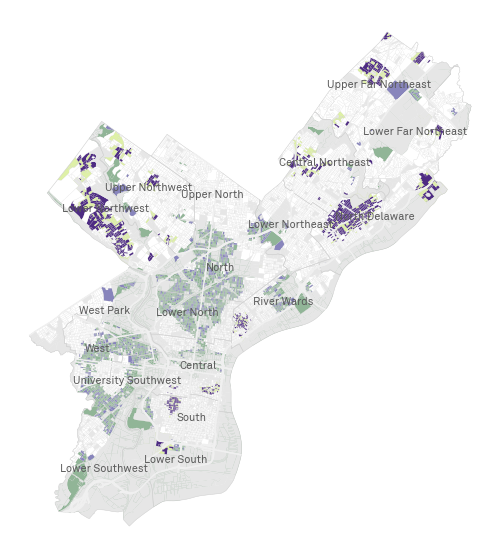

In [63]:
## single owner export as svg 

moran_list = [moran2018_loc_occ]
files_list = ['occ2018_altLL.svg']
years = ['2018']

# moran_list = [moran2018_loc_occ]
# files_list = ['occ2018.png']
# years = ['2018']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#e6e6e6');

#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);    
#     ax.set_title(years[i])
    plt.savefig('../exports/'+files_list[i],dpi=300,format='svg')


/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


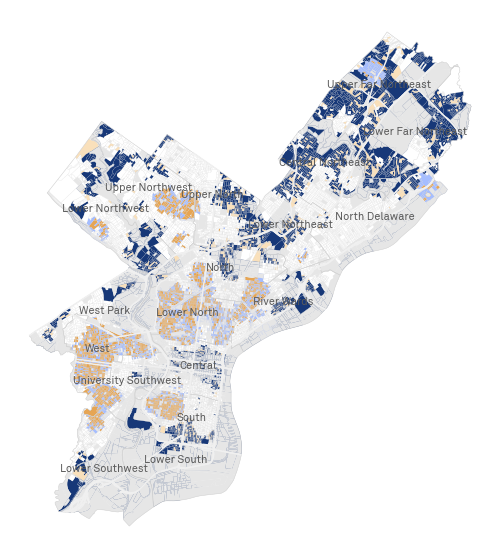

In [57]:
# single investor export
moran_list = [moran2018_loc]
files_list = ['inv2018_alt_grey.svg']
years = ['2018']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#e6e6e6')

#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    plt.savefig('../exports/'+files_list[i],dpi=300,format='svg')


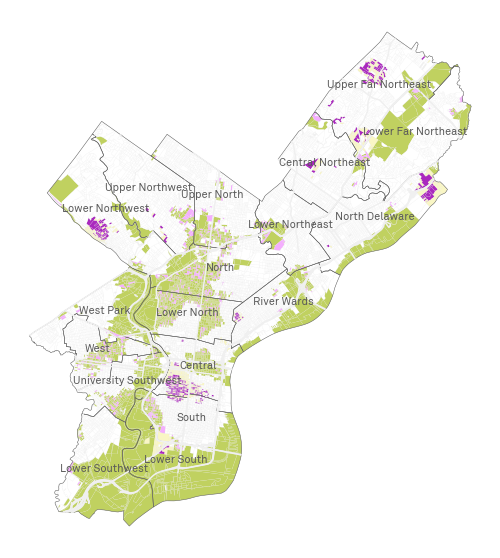

In [80]:
## method to batch export individual plots OWNER 

moran_list = [moran2000_loc_occ, moran2001_loc_occ, moran2002_loc_occ,moran2003_loc_occ, moran2004_loc_occ,moran2005_loc_occ, moran2006_loc_occ,moran2007_loc_occ, moran2008_loc_occ,moran2009_loc_occ]
files_list = ['occ2000.png','occ2001.png','occ2002.png','occ2003.png','occ2004.png','occ2005.png','occ2006.png','occ2007.png','occ2008.png','occ2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False);
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5');

    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/philly_morans/'+files_list[i],dpi=500)
    
## method to batch export individual plots OWNER 

moran_list = [moran2010_loc_occ, moran2011_loc_occ, moran2012_loc_occ,moran2013_loc_occ, moran2014_loc_occ,moran2015_loc_occ, moran2016_loc_occ,moran2017_loc_occ, moran2018_loc_occ]
files_list = ['occ2010.png','occ2011.png','occ2012.png','occ2013.png','occ2014.png','occ2015.png','occ2016.png','occ2017.png','occ2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']

# moran_list = [moran2018_loc_occ]
# files_list = ['occ2018.png']
# years = ['2018']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5');

#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);    
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/philly_morans/'+files_list[i],dpi=500)


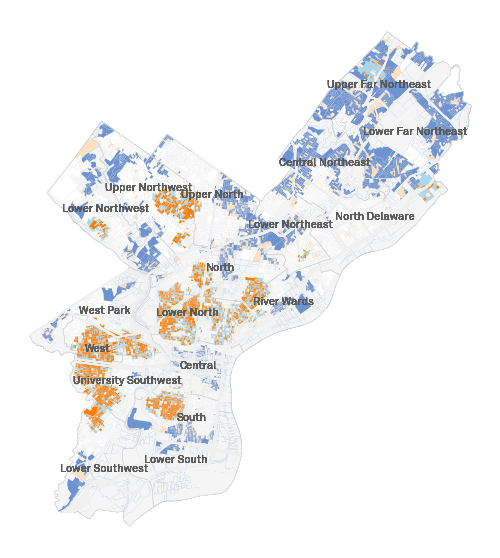

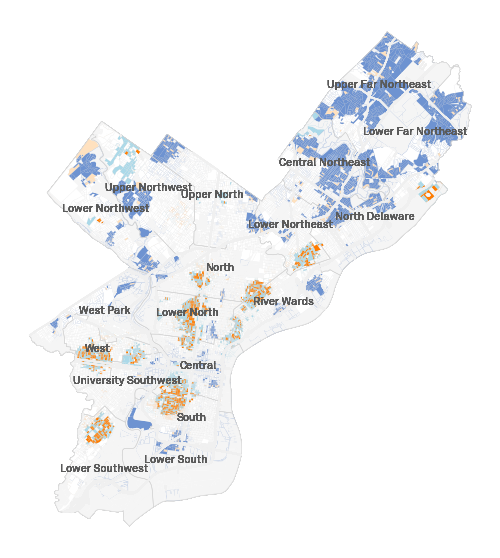

In [44]:
## method to batch export individual plots INVESTOR 

moran_list = [moran2010_loc, moran2011_loc, moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc]
files_list = ['inv2010.png','inv2011.png','inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
# moran_list = [ moran2018_loc]
# files_list = ['inv2018.png']
# years = ['2018']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/philly_morans/'+files_list[i],dpi=300)

    
moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/philly_morans/'+files_list[i],dpi=300)


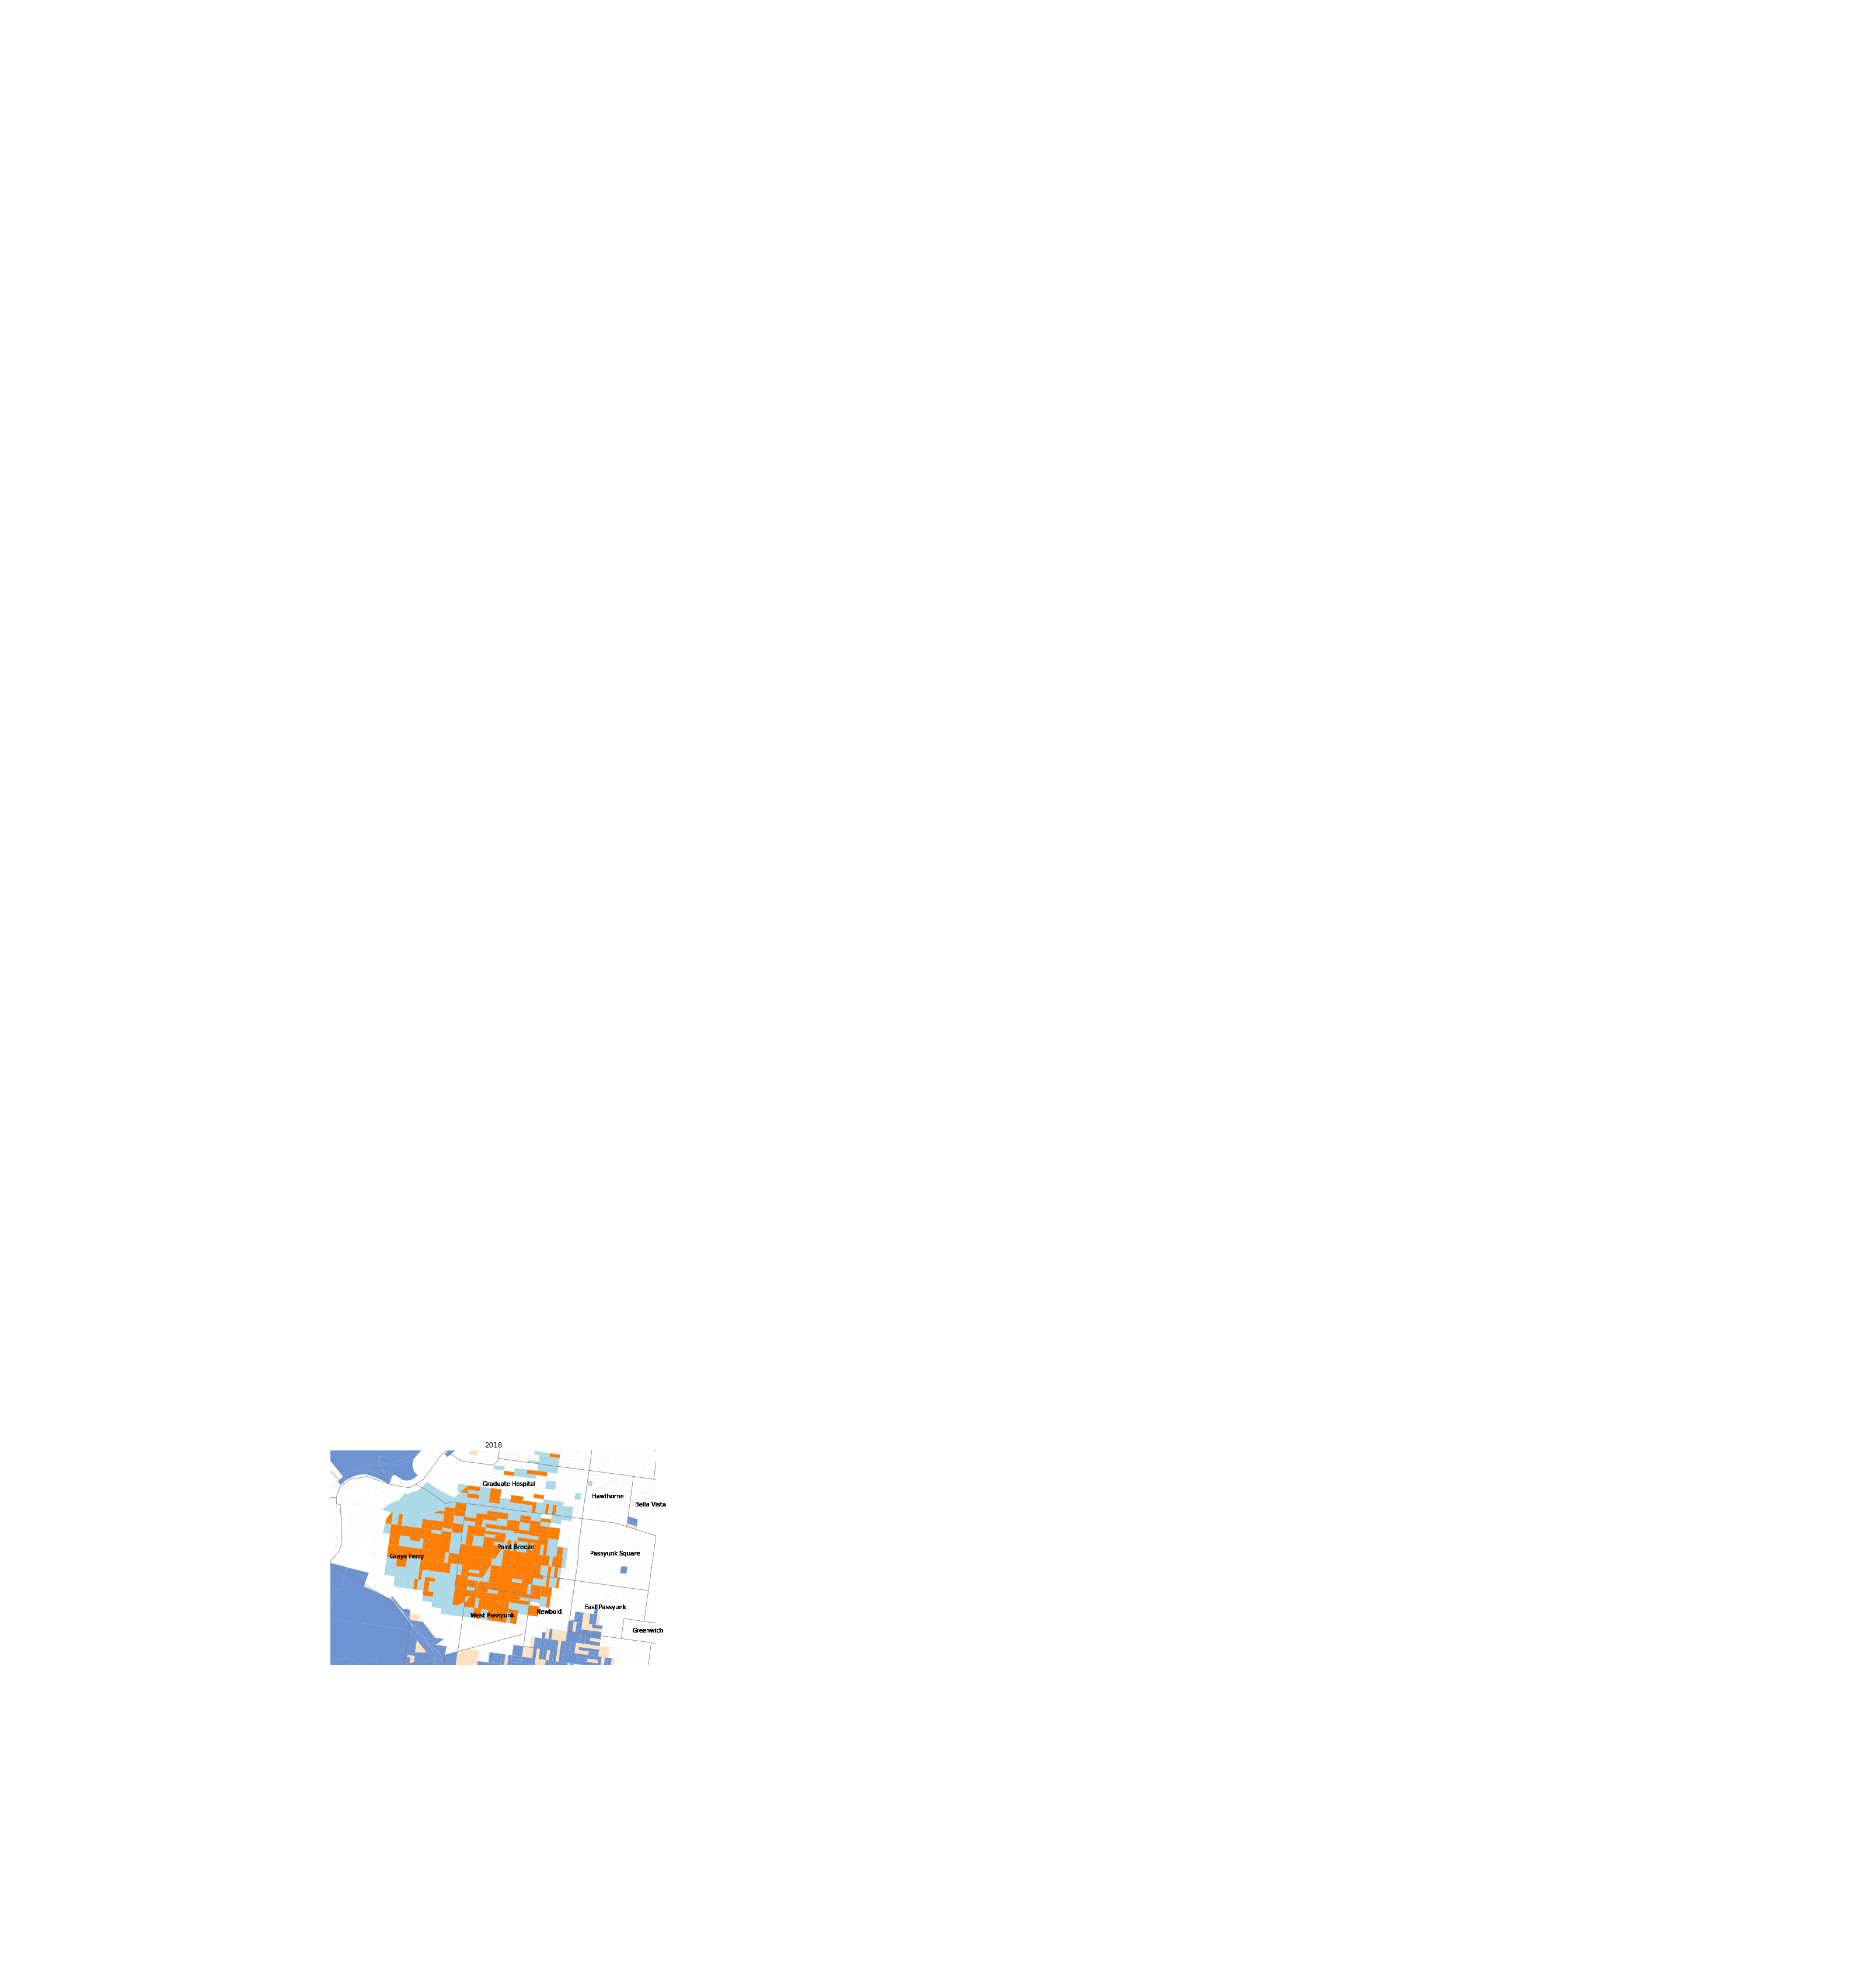

In [133]:
# point_breeze neighborhood zoom investor 2010-2018

moran_list = [moran2010_loc, moran2011_loc, moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc]
# basemap = grouped_deeds10_18_i
files_list = ['inv2010.png','inv2011.png','inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
xlim = ([pointbreeze.total_bounds[0],pointbreeze.total_bounds[2]])
ylim = ([pointbreeze.total_bounds[1],pointbreeze.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
    neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(years[i])
    plt.savefig('02_outputs/complete_drafts/neighborhoods/point_breeze/pointbreeze'+files_list[i])


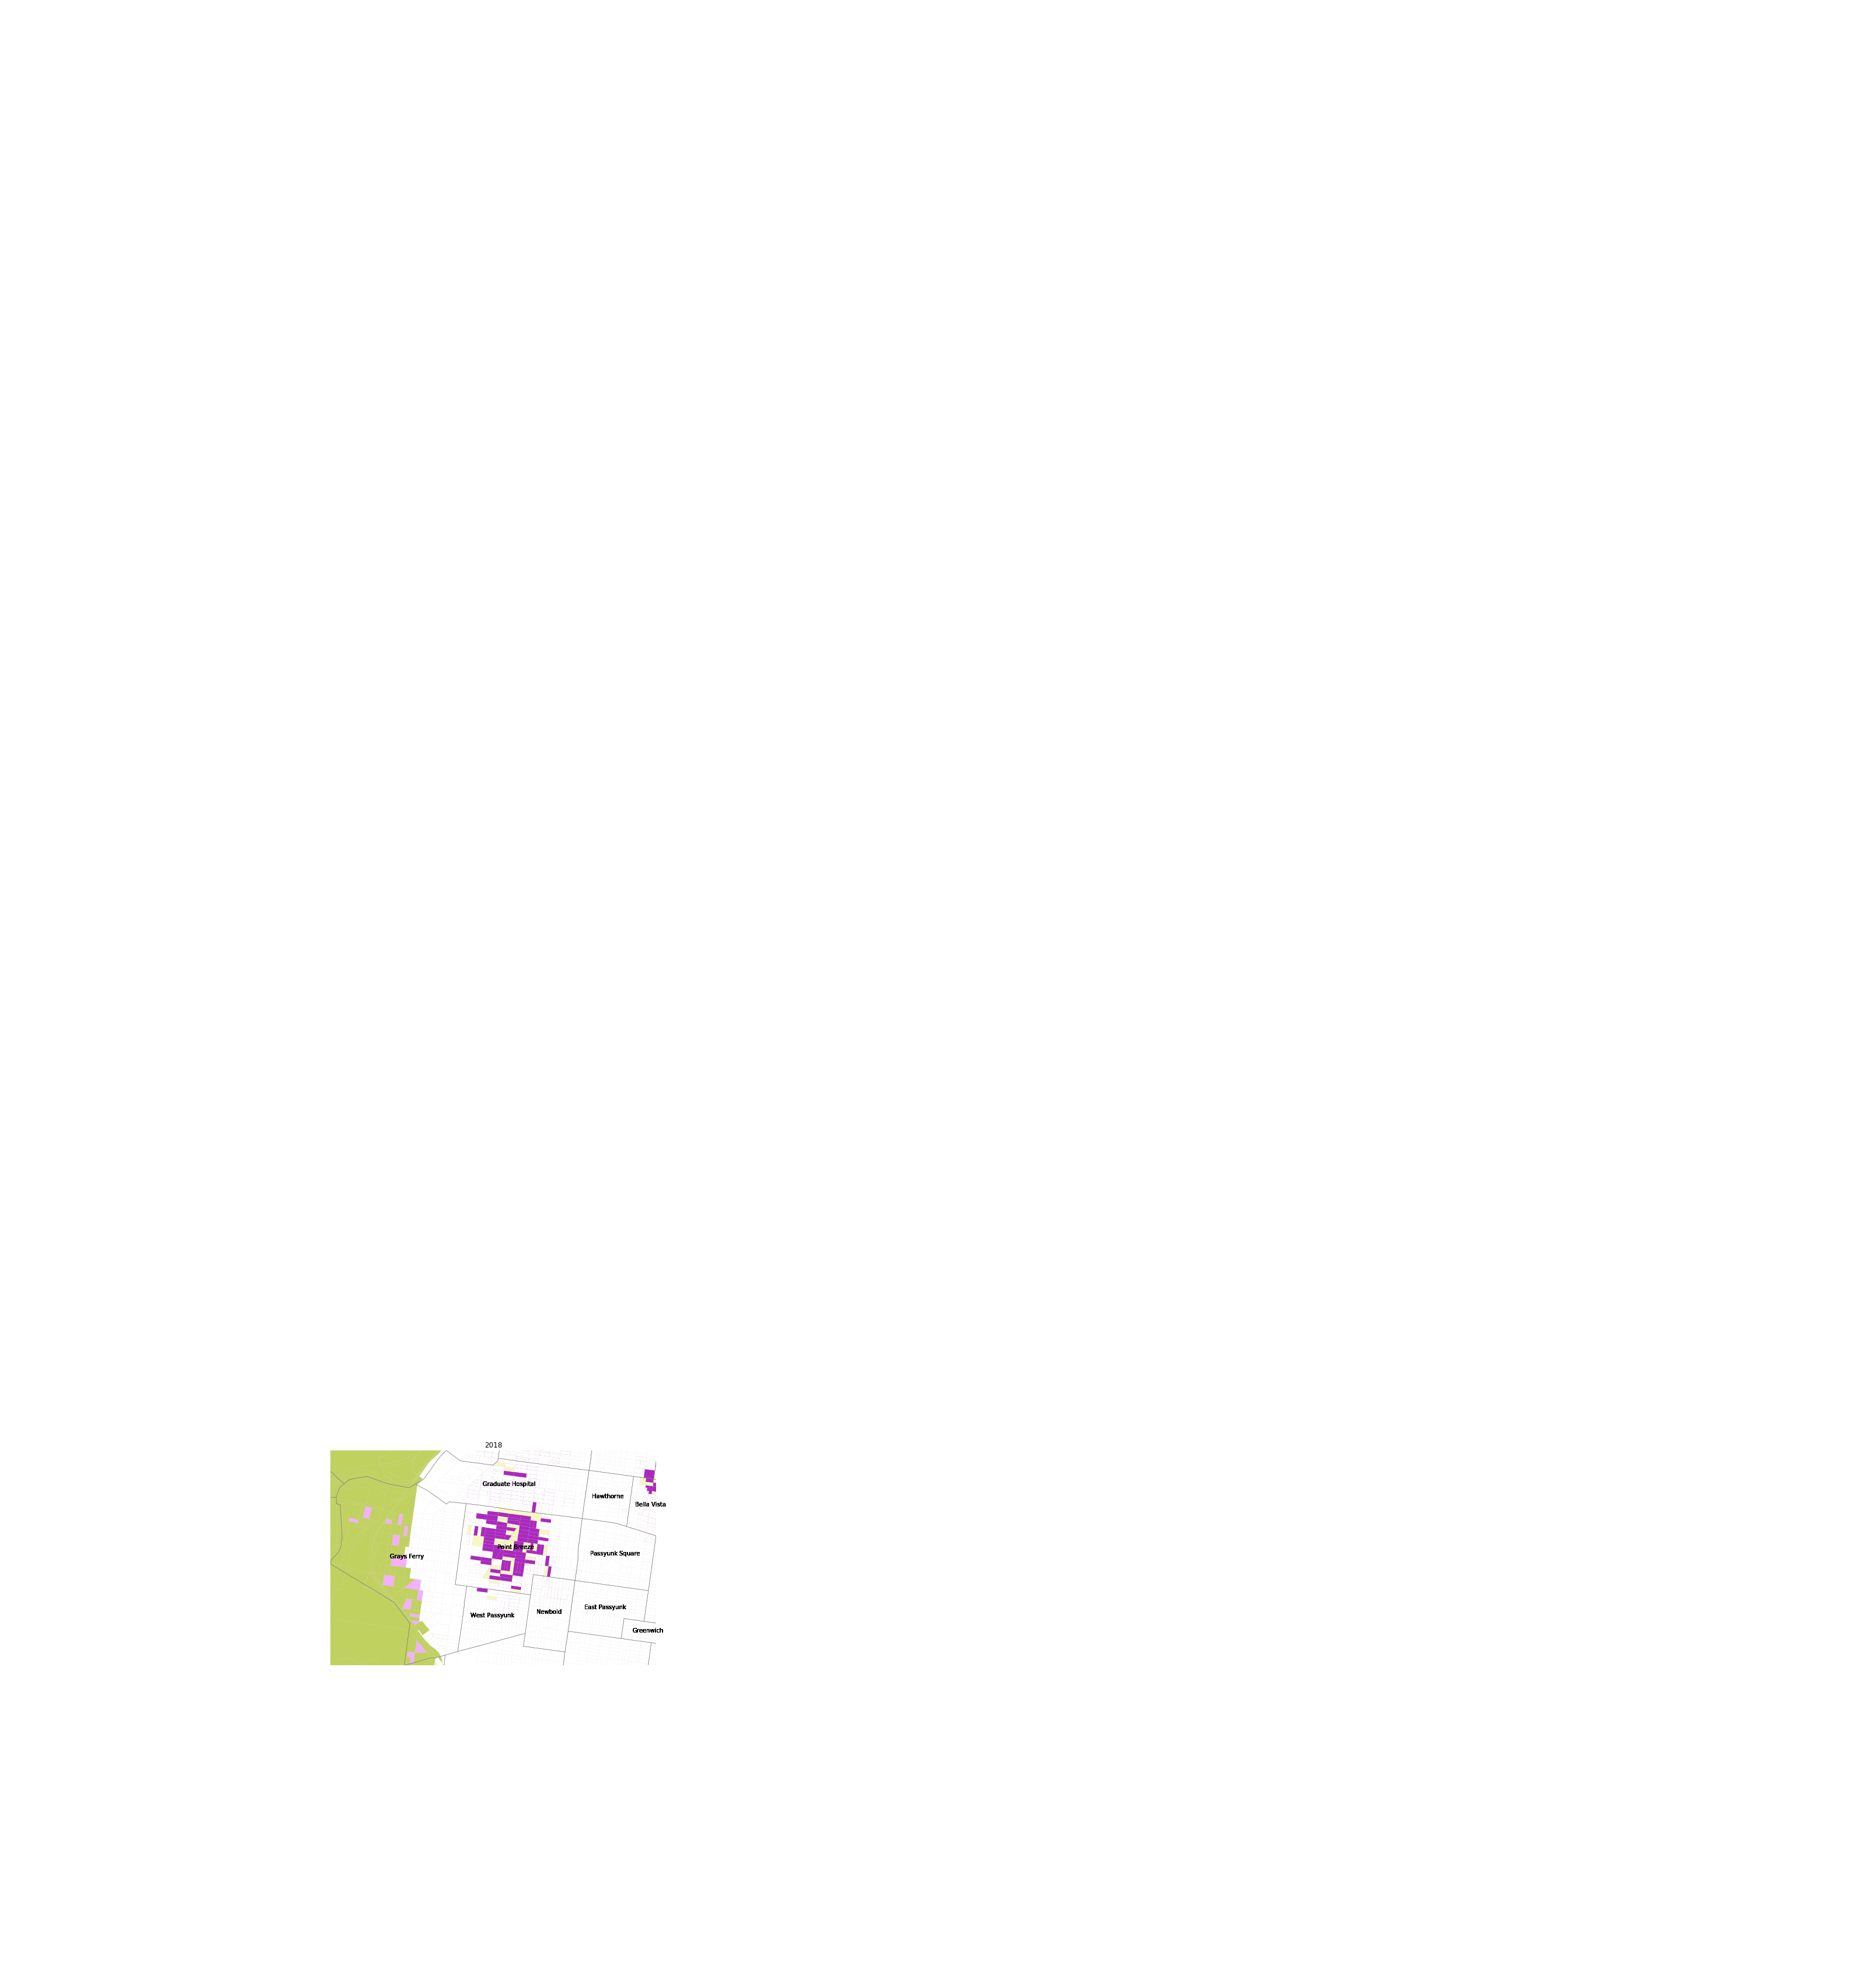

In [134]:
# point_breeze neighborhood zoom  2010-2018 OWNER

moran_list = [moran2010_loc_occ, moran2011_loc_occ, moran2012_loc_occ,moran2013_loc_occ, moran2014_loc_occ,moran2015_loc_occ, moran2016_loc_occ,moran2017_loc_occ, moran2018_loc_occ]
# basemap = grouped_deeds10_18_i
files_list = ['occ2010.png','occ2011.png','occ2012.png','occ2013.png','occ2014.png','occ2015.png','occ2016.png','occ2017.png','occ2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
xlim = ([pointbreeze.total_bounds[0],pointbreeze.total_bounds[2]])
ylim = ([pointbreeze.total_bounds[1],pointbreeze.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
    neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(years[i])
    plt.savefig('02_outputs/complete_drafts/neighborhoods/point_breeze/pointbreeze'+files_list[i])


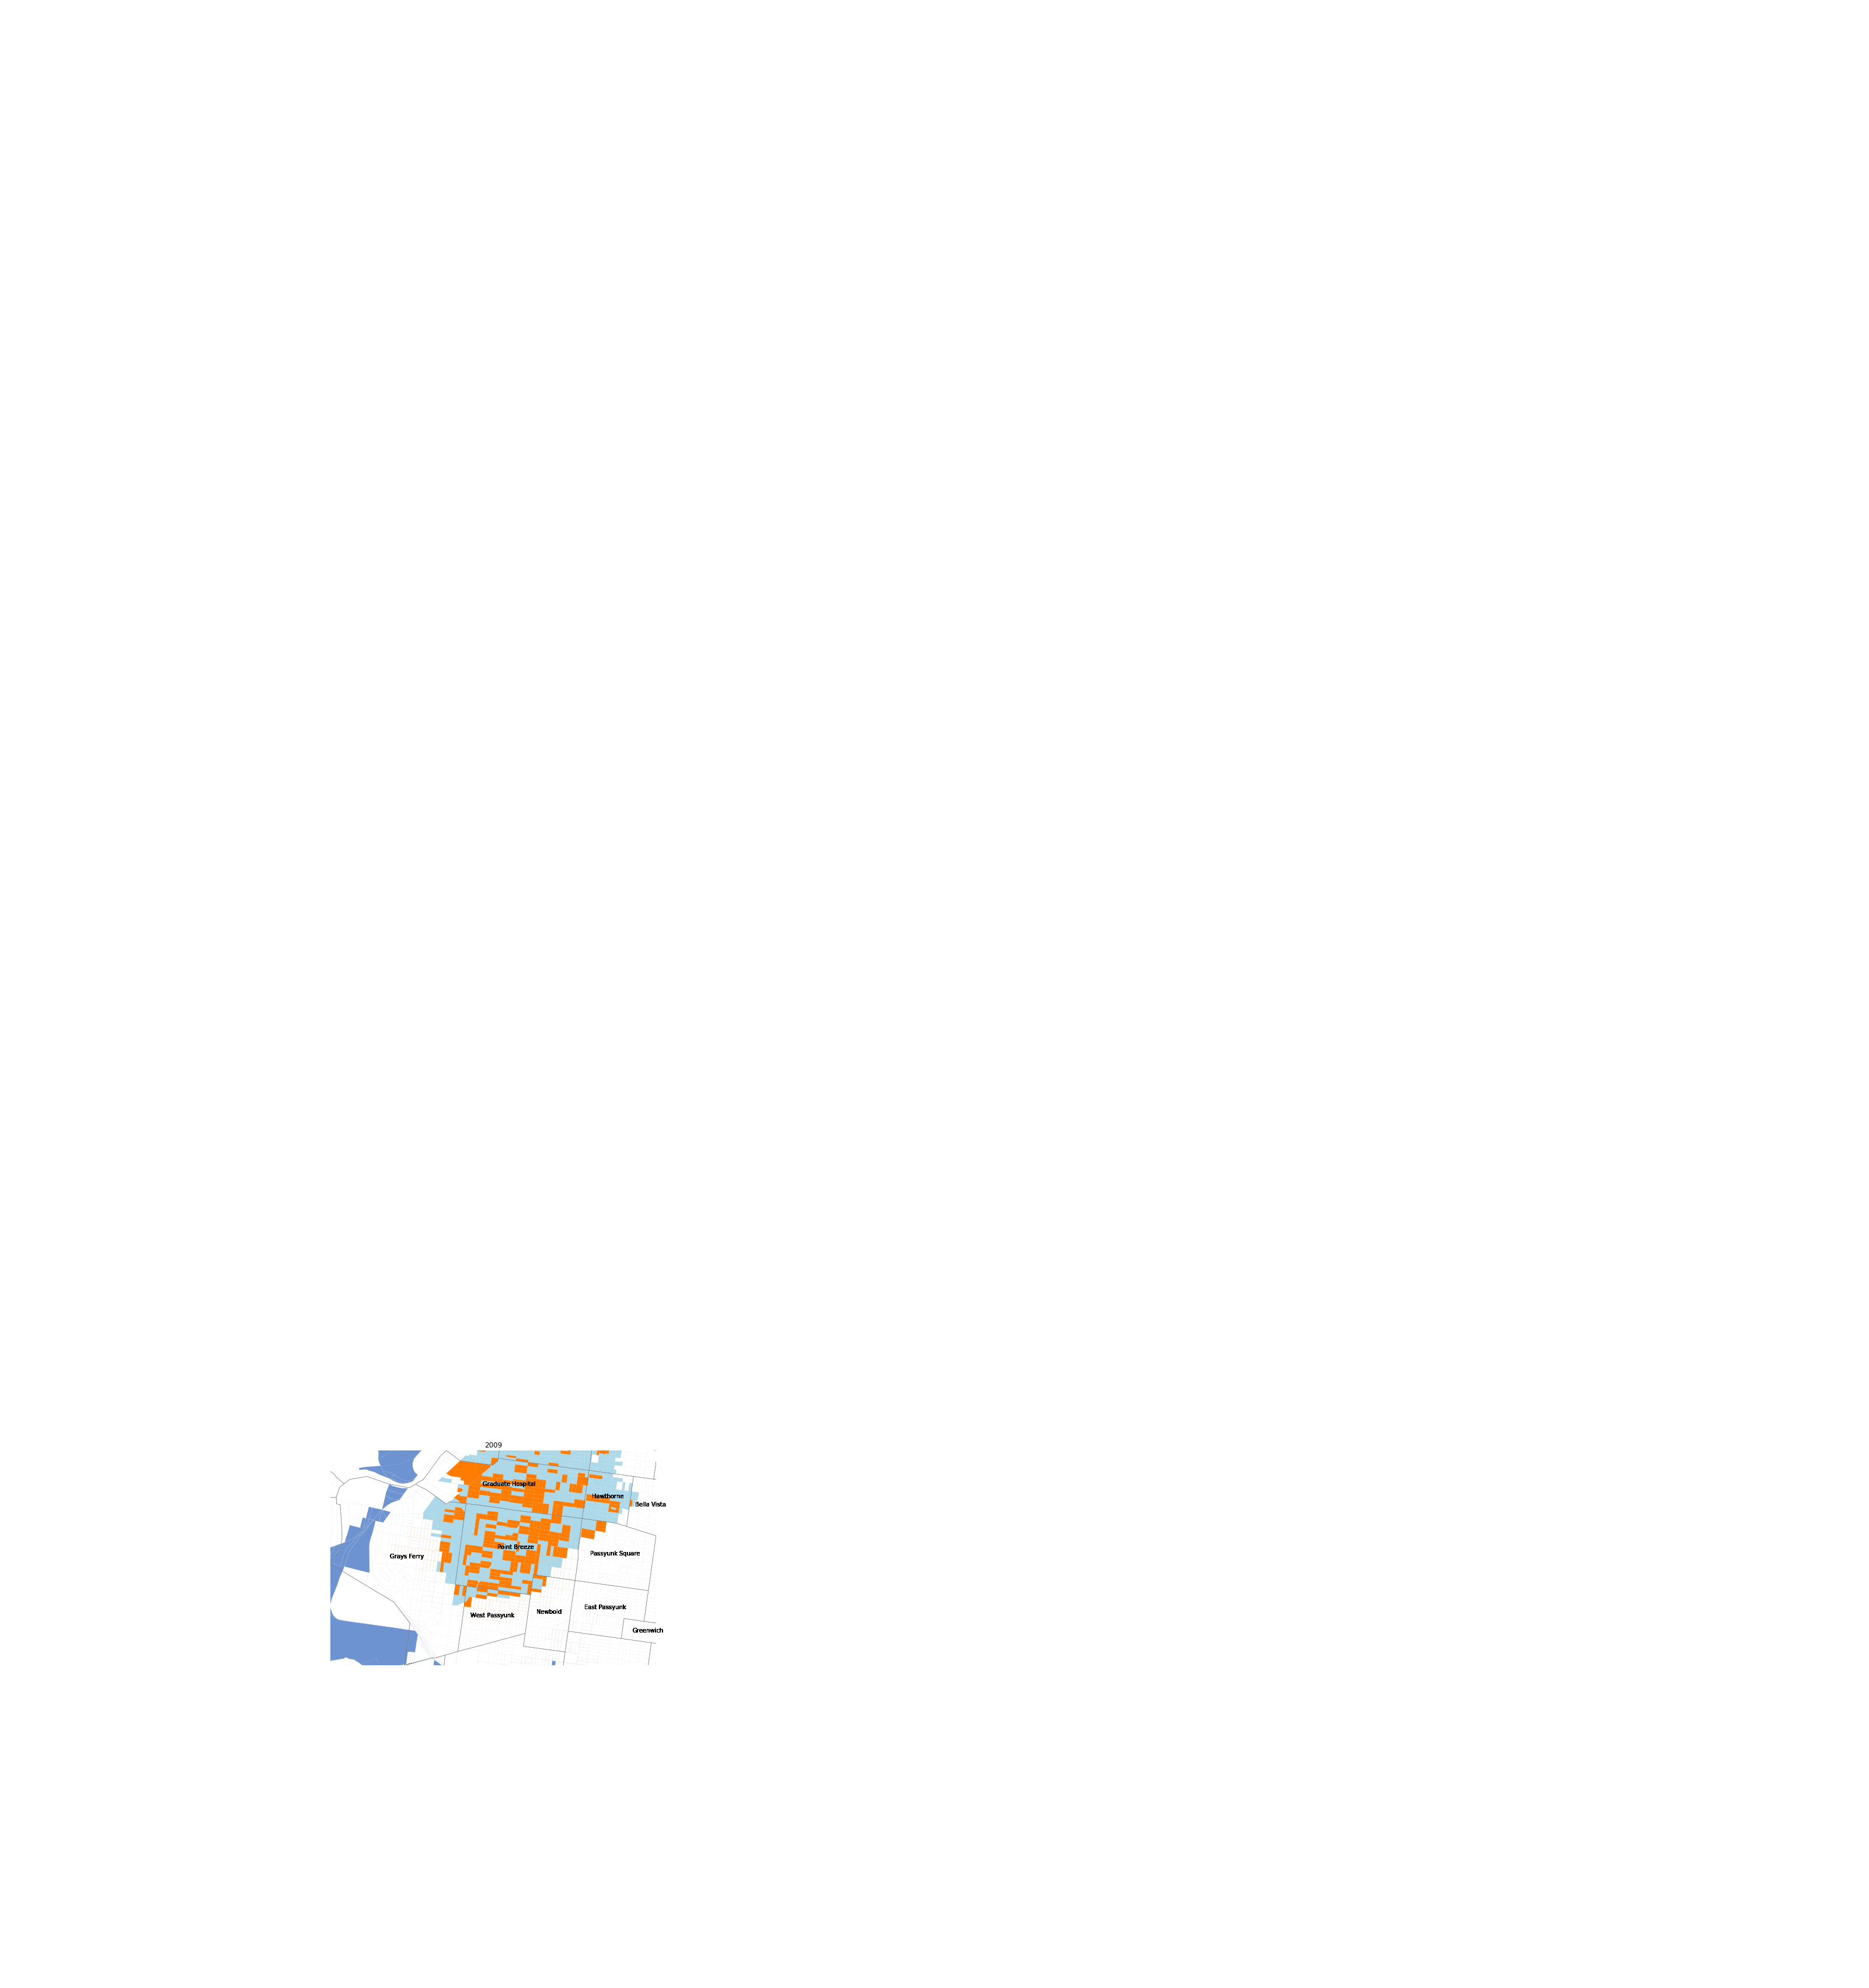

In [135]:
# point breeze neighborhood zoom investor 2000-2009 

# moran_list = [moran2000_loc, moran2001_loc]
# files_list = ['inv2000.png','inv2001.png']
# years = ['2000','2001']


moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
xlim = ([pointbreeze.total_bounds[0],pointbreeze.total_bounds[2]])
ylim = ([pointbreeze.total_bounds[1],pointbreeze.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
    neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(years[i])
    plt.savefig('02_outputs/complete_drafts/neighborhoods/point_breeze/pointbreeze'+files_list[i])


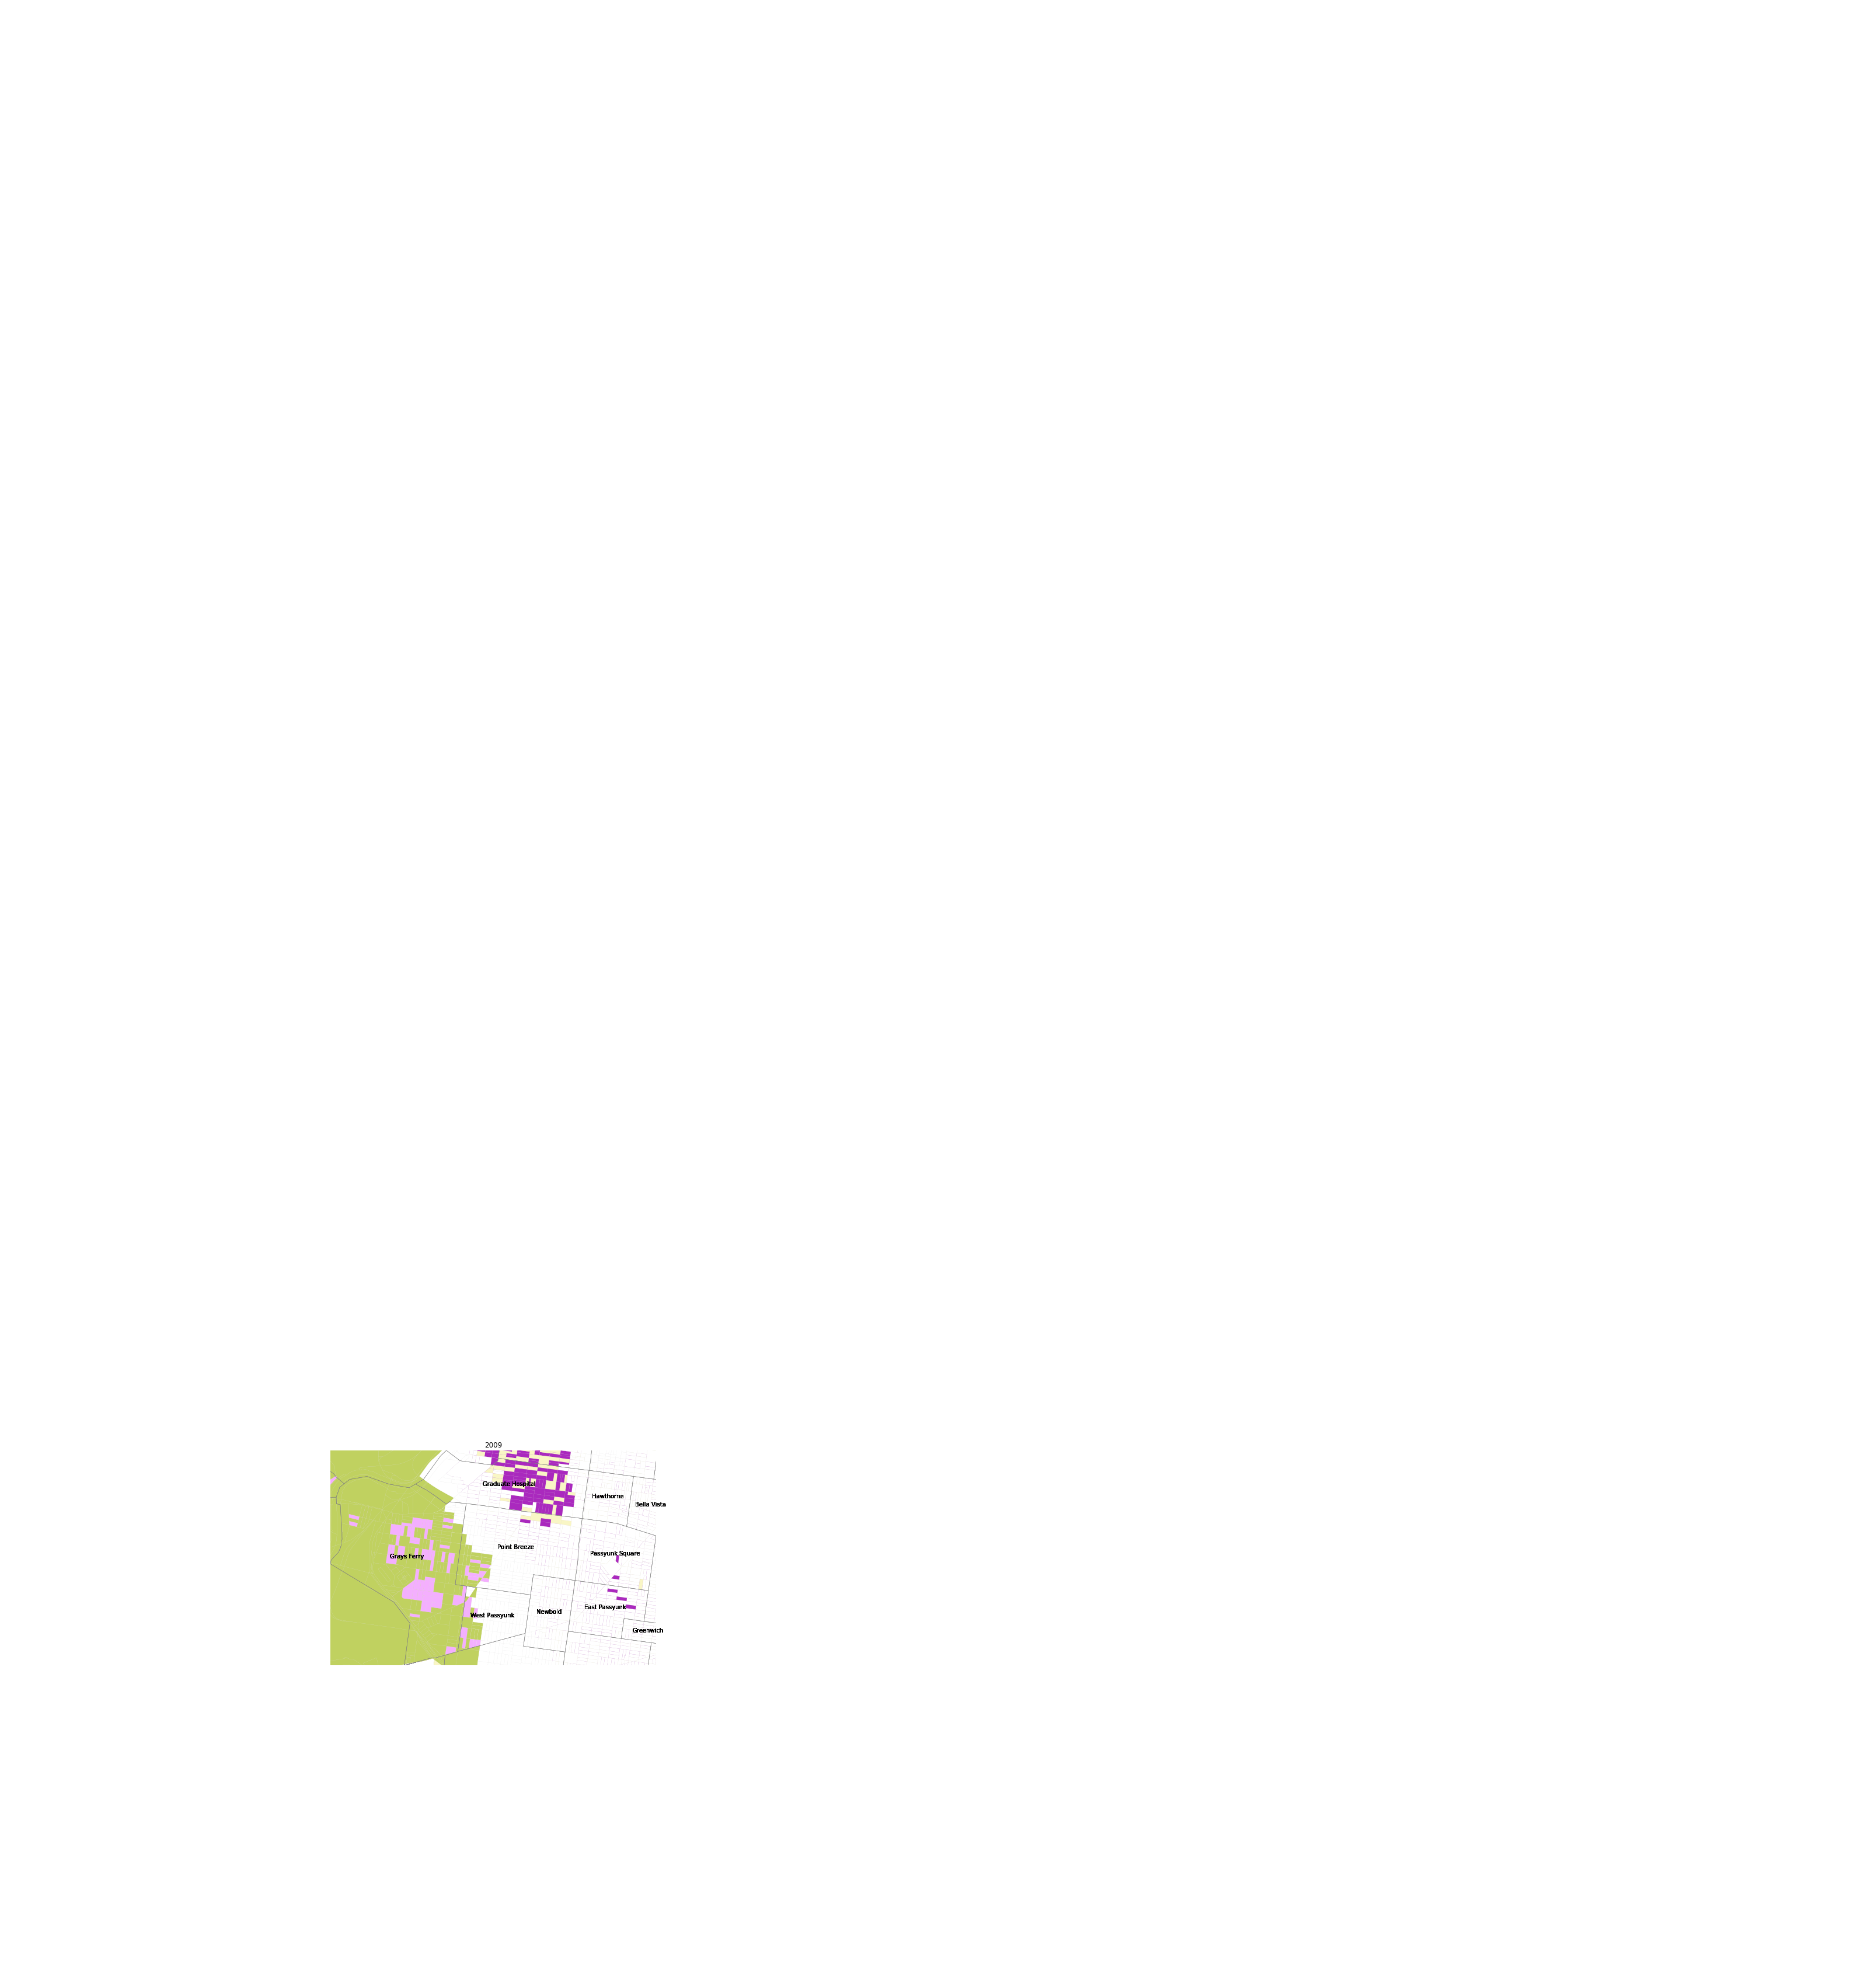

In [136]:
# point breeze neighborhood zoom OWNER 2000-2009 

# moran_list = [moran2000_loc_occ, moran2001_loc_occ]
# files_list = ['occ2000.png','occ2001.png']
# years = ['2000','2001']


moran_list = [moran2000_loc_occ, moran2001_loc_occ, moran2002_loc_occ,moran2003_loc_occ, moran2004_loc_occ,moran2005_loc_occ, moran2006_loc_occ,moran2007_loc_occ, moran2008_loc_occ,moran2009_loc_occ]
files_list = ['occ2000.png','occ2001.png','occ2002.png','occ2003.png','occ2004.png','occ2005.png','occ2006.png','occ2007.png','occ2008.png','occ2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
xlim = ([pointbreeze.total_bounds[0],pointbreeze.total_bounds[2]])
ylim = ([pointbreeze.total_bounds[1],pointbreeze.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
    neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(years[i])
    plt.savefig('02_outputs/complete_drafts/neighborhoods/point_breeze/pointbreeze'+files_list[i])


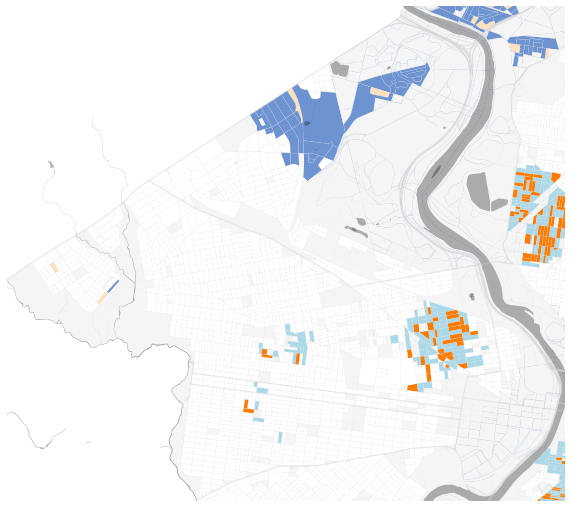

In [25]:
# west_philly neighborhood zoom investor 2010-2018

moran_list = [moran2010_loc]
files_list = ['inv2010.png']
years = ['2010']
xlim = ([westPhilly.total_bounds[0],westPhilly.total_bounds[2]])
ylim = ([westPhilly.total_bounds[1],westPhilly.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False);
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    neighborhoods.plot(ax=ax,facecolor='none',edgecolor='darkgrey',linewidth=0.5);
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    water_all.plot(ax=ax, color="#000000", edgecolor='none', alpha=.3);
    roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3);
    roads_formap.plot(ax=ax, color="lightgrey", alpha=.3);
    ax.set_xlim(xlim);
    ax.set_ylim(ylim);
#     ax.set_title(years[i]);
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/west_philly/west_philly_test2'+files_list[i])




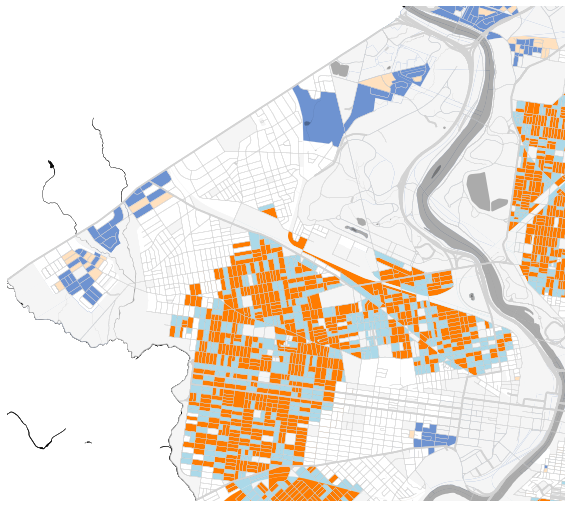

In [26]:
# west_philly neighborhood zoom investor 2010-2018

moran_list = [moran2010_loc, moran2011_loc, moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc]
# basemap = grouped_deeds10_18_i
files_list = ['inv2010.png','inv2011.png','inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
xlim = ([westPhilly.total_bounds[0],westPhilly.total_bounds[2]])
ylim = ([westPhilly.total_bounds[1],westPhilly.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.3);
    roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3);
    roads_formap.plot(ax=ax, color="lightgrey", alpha=.3);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/west_philly/west_philly'+files_list[i])


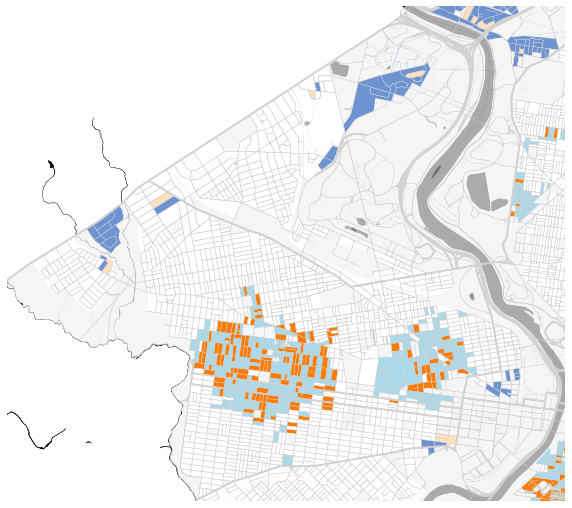

In [27]:
# west_philly neighborhood zoom investor 2000-2009

# moran_list = [moran2000_loc, moran2001_loc]
# files_list = ['inv2000.png','inv2001.png']
# years = ['2000','2001']


moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
xlim = ([westPhilly.total_bounds[0],westPhilly.total_bounds[2]])
ylim = ([westPhilly.total_bounds[1],westPhilly.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.3);
    roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3);
    roads_formap.plot(ax=ax, color="lightgrey", alpha=.3);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/west_philly/west_philly'+files_list[i])


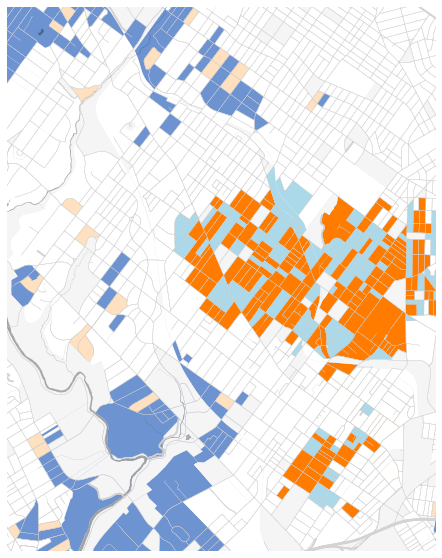

In [28]:
# germantown neighborhood zoom 2010-2018

moran_list = [moran2010_loc, moran2011_loc, moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc]
# basemap = grouped_deeds10_18_i
files_list = ['inv2010.png','inv2011.png','inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
xlim = ([germantown.total_bounds[0],germantown.total_bounds[2]])
ylim = ([germantown.total_bounds[1],germantown.total_bounds[3]])


fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    
#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    water.plot(ax=ax, color="#000000", edgecolor='none', alpha=.3);
    roads_minorformap.plot(ax=ax, color="lightgrey", linewidth =0.25, alpha=0.3);
    roads_formap.plot(ax=ax, color="lightgrey", alpha=.3);

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/germantown/germantown'+files_list[i])


for:inv2000.png
for:inv2001.png
for:inv2002.png
for:inv2003.png
for:inv2004.png
for:inv2005.png
for:inv2006.png
for:inv2007.png
for:inv2008.png
for:inv2009.png


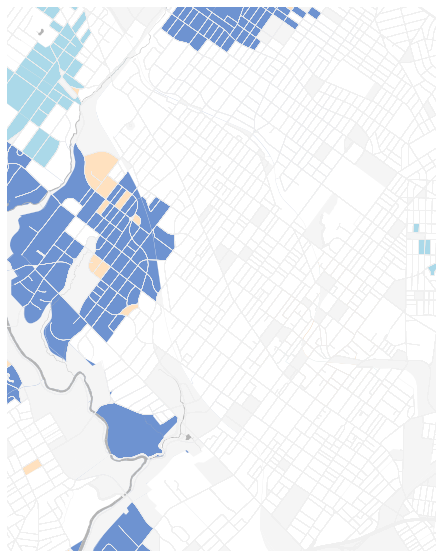

In [29]:
# germantown neighborhood zoom 2000-2009

moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
xlim = ([germantown.total_bounds[0],germantown.total_bounds[2]])
ylim = ([germantown.total_bounds[1],germantown.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center',fontname="Akkurat Pro"),axis=1);
    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
    roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center',fontname="Akkurat Pro"),axis=1);
  
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    print("for:"+files_list[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/germantown/germantown'+files_list[i])
#     ax.set_title(years[i])
# print(files_list[i])



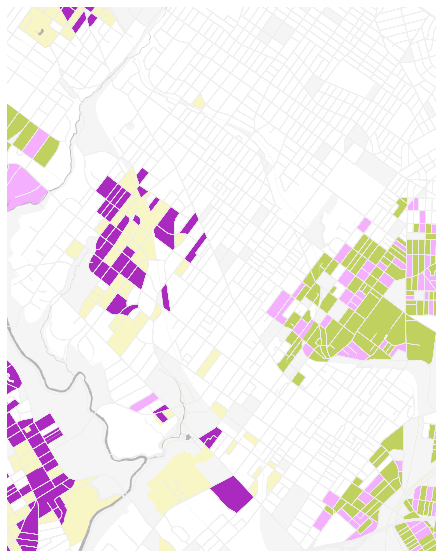

In [32]:
# germantown neighborhood zoom 2000-2009 OWNER

moran_list = [moran2000_loc_occ, moran2001_loc_occ, moran2002_loc_occ,moran2003_loc_occ, moran2004_loc_occ,moran2005_loc_occ, moran2006_loc_occ,moran2007_loc_occ, moran2008_loc_occ,moran2009_loc_occ]
files_list = ['occ2000.png','occ2001.png','occ2002.png','occ2003.png','occ2004.png','occ2005.png','occ2006.png','occ2007.png','occ2008.png','occ2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
xlim = ([germantown.total_bounds[0],germantown.total_bounds[2]])
ylim = ([germantown.total_bounds[1],germantown.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
    roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/germantown/germantown'+files_list[i])


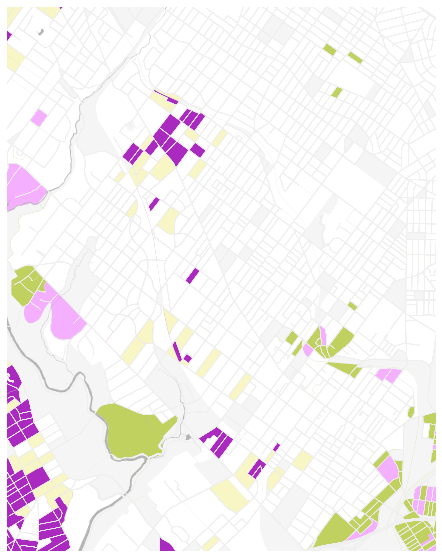

In [30]:
# germantown neighborhood zoom 2010-2018 OWNER

moran_list = [moran2010_loc_occ, moran2011_loc_occ, moran2012_loc_occ,moran2013_loc_occ, moran2014_loc_occ,moran2015_loc_occ, moran2016_loc_occ,moran2017_loc_occ, moran2018_loc_occ]
# basemap = grouped_deeds10_18_i
files_list = ['occ2010.png','occ2011.png','occ2012.png','occ2013.png','occ2014.png','occ2015.png','occ2016.png','occ2017.png','occ2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
xlim = ([germantown.total_bounds[0],germantown.total_bounds[2]])
ylim = ([germantown.total_bounds[1],germantown.total_bounds[3]])


fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);
    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
    roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/germantown/germantown'+files_list[i])


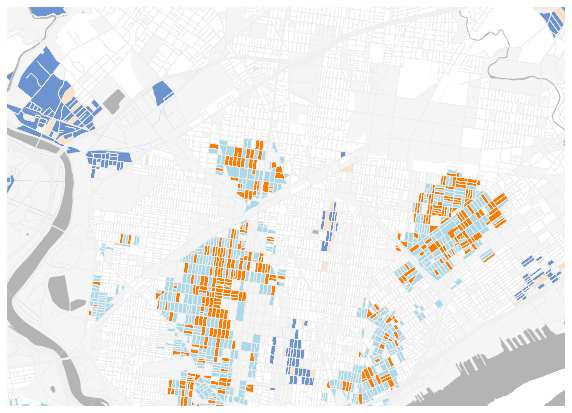

In [31]:
# north philly neighborhood zoom 2000-2009


moran_list = [moran2000_loc, moran2001_loc, moran2002_loc,moran2003_loc, moran2004_loc,moran2005_loc, moran2006_loc,moran2007_loc, moran2008_loc,moran2009_loc]
files_list = ['inv2000.png','inv2001.png','inv2002.png','inv2003.png','inv2004.png','inv2005.png','inv2006.png','inv2007.png','inv2008.png','inv2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
xlim = ([northphilly.total_bounds[0],northphilly.total_bounds[2]])
ylim = ([northphilly.total_bounds[1],northphilly.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);    
    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
    roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/north_philly/northphilly'+files_list[i])


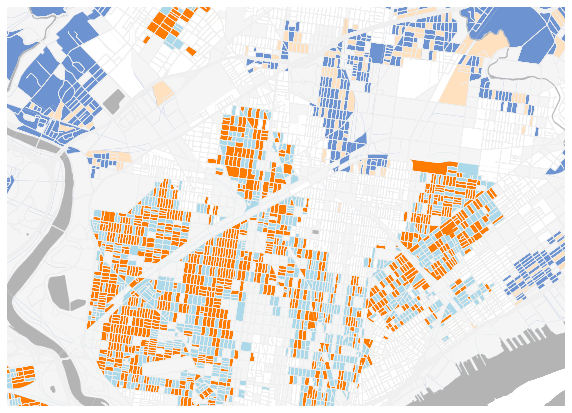

In [33]:
# north philly  neighborhood zoom 2010-2018

moran_list = [moran2010_loc, moran2011_loc, moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc]
# basemap = grouped_deeds10_18_i
files_list = ['inv2010.png','inv2011.png','inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
xlim = ([northphilly.total_bounds[0],northphilly.total_bounds[2]])
ylim = ([northphilly.total_bounds[1],northphilly.total_bounds[3]])


fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    
#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);    
    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
    roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/north_philly/northphilly'+files_list[i])


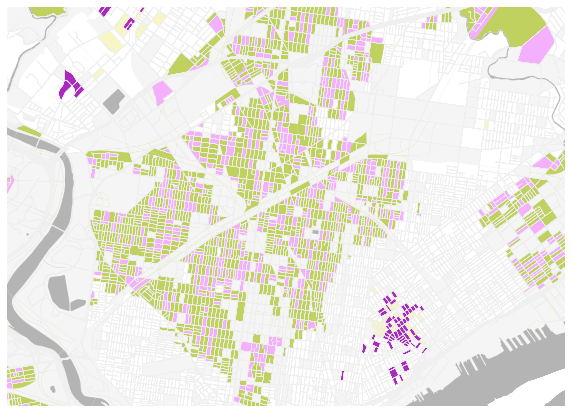

In [34]:
# north philly  neighborhood zoom 2010-2018 OWNER

moran_list = [moran2010_loc_occ, moran2011_loc_occ, moran2012_loc_occ,moran2013_loc_occ, moran2014_loc_occ,moran2015_loc_occ, moran2016_loc_occ,moran2017_loc_occ, moran2018_loc_occ]
files_list = ['occ2010.png','occ2011.png','occ2012.png','occ2013.png','occ2014.png','occ2015.png','occ2016.png','occ2017.png','occ2018.png']
years = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
xlim = ([northphilly.total_bounds[0],northphilly.total_bounds[2]])
ylim = ([northphilly.total_bounds[1],northphilly.total_bounds[3]])


fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds10_18_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);    
    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
    roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/north_philly/northphilly'+files_list[i])


KeyboardInterrupt: 

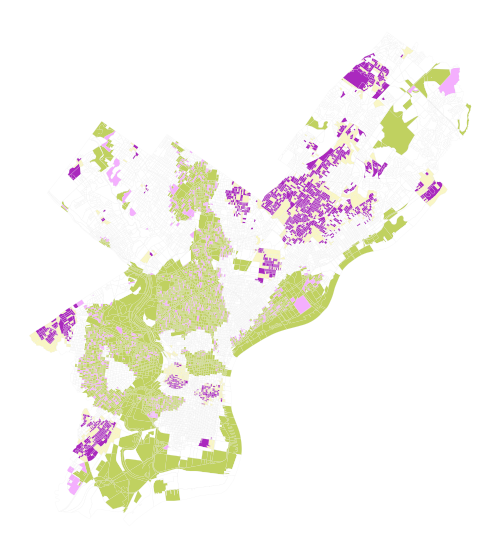

In [40]:
# north philly neighborhood zoom 2000-2009 OWNER


moran_list = [moran2000_loc_occ, moran2001_loc_occ, moran2002_loc_occ,moran2003_loc_occ, moran2004_loc_occ,moran2005_loc_occ, moran2006_loc_occ,moran2007_loc_occ, moran2008_loc_occ,moran2009_loc_occ]
files_list = ['occ2000.png','occ2001.png','occ2002.png','occ2003.png','occ2004.png','occ2005.png','occ2006.png','occ2007.png','occ2008.png','occ2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']
xlim = ([northphilly.total_bounds[0],northphilly.total_bounds[2]])
ylim = ([northphilly.total_bounds[1],northphilly.total_bounds[3]])

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

#     neighborhoods.plot(ax=ax,facecolor='none',edgecolor='grey',linewidth=0.5)
#     neighborhoods.apply(lambda x: ax.annotate(s=x.mapname, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);    
    water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
    roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/neighborhoods/north_philly/northphilly'+files_list[i])


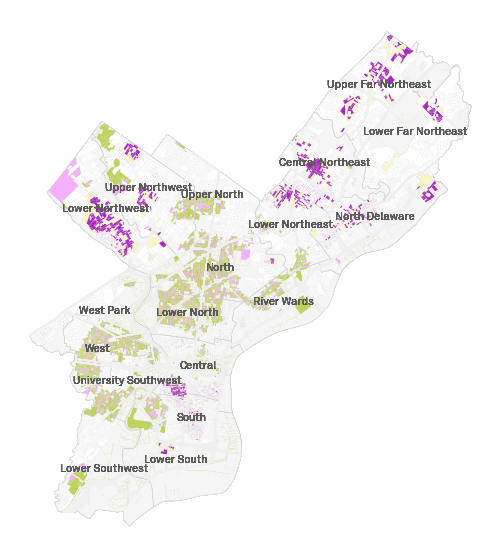

In [43]:
 
moran_list = [moran2000_loc_occ, moran2001_loc_occ, moran2002_loc_occ, 
              moran2003_loc_occ, moran2004_loc_occ,moran2005_loc_occ,
              moran2006_loc_occ,moran2007_loc_occ, moran2008_loc_occ,
              moran2009_loc_occ]
files_list = ['occ2000.png','occ2001.png','occ2002.png','occ2003.png','occ2004.png','occ2005.png','occ2006.png','occ2007.png','occ2008.png','occ2009.png']
years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    lisa_cluster_cust(colors_owner,val, grouped_deeds00_10_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')

                                        
#     water.plot(ax=ax, color="#B4B4B4", edgecolor='none', );
#     roads_minorformap.plot(ax=ax, color="#F0F0F0", linewidth =0.25, );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    planning_districts.plot(ax=ax,facecolor='none',edgecolor='#D2D2D2',linewidth=0.5)
    districts.apply(lambda x: ax.annotate(s=x.DIST_NAME, xy=x.geometry.centroid.coords[0],
                                          ha='center',fontname="Akkurat Pro", fontsize=11,color='#5A5A5A'),axis=1);
#     ax.set_title(years[i])
    plt.savefig('../05_drawings/02_outputs/complete_drafts/philly_morans/'+files_list[i],dpi=300)
